# Quant Portfolio Modeling (QPM) Project
This notebook replicates the QPM pipeline with rolling windows, PCA, clustering, ARIMA-GARCH modeling, vine copulas, and portfolio optimization.

## 1. Imports and Libraries
Import necessary Python packages for statistics, econometrics, copulas, and optimization.

In [1]:
# ================= INSTALL REQUIRED LIBRARIES =================
# Run these once before imports
# !pip install scikit-learn
# !pip install matplotlib
# !pip install statsmodels
# !pip install arch
# !pip install numpy
# !pip install pandas
# !pip install pyvinecopulib
# !pip install scipy
# !pip install cvxopt
# !pip install python-dateutil
# !pip install hmmlearn scikit-learn pandas numpy statsmodels matplotlib

# ================= IMPORTS =================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import numpy as np
import pandas as pd
import pyvinecopulib as pv
from scipy.stats import rankdata, kurtosis, skew, jarque_bera, norm, jf_skew_t
from datetime import datetime
from cvxopt import matrix, solvers
from dateutil.relativedelta import relativedelta
from hmmlearn.hmm import GaussianHMM
import os, re
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Optional, Callable 

## TL;DR — HMM Regime Detection (Code Summary)
- **Training set**:  
  2-year Price data starting from 2017-01-01 → 2022-01-01
  
- **Rolling Windows**:  
  Create 3-month rolling windows from  using past-only data.

- **Data Loading**:  
  Read Excel file, parse `Date%` as datetime, and set as index.

- **Feature Engineering (`make_features`)**:  
  - Daily return (`ret_d1`)  
  - Volatility ladders: 30, 60, 90 days  
  - Momentum ladders (log diffs)  
  - Skew and kurtosis (63 days)  
  - Tail clipping + rolling z-scores for robustness  

- **Fit HMM (`fit_hmm_past_window`)**:  
  - GaussianHMM with 3 states  
  - Map states → Bear / Neutral / Bull by mean return  
  - Output: model, features, states, posteriors, mean returns, last signal  

- **Plot Diagnostics (`plot_regime_diagnostics`)**:  
  Produces 5 plots and saves to *QPM plots*:  
  1. Price with regime shading  
  2. State posterior probabilities  
  3. Feature scatter (`ret_d1` vs volatility)  
  4. Transition matrix heatmap  
  5. Mean return by state  

- **Utility**:  
  `ensure_price_column` rebuilds price from returns if missing.


In [2]:
outdir = "QPM plots"
os.makedirs(outdir, exist_ok=True)
# Define the initial start date and end date
start_date = datetime(2017, 1, 1)
end_date = datetime(2018, 12, 31)
final_end_date = datetime(2023, 12, 31)
# # Create a list to store the rolling windows
rolling_windows = []
window_size = relativedelta(months=3)
# # Generate the rolling windows
while end_date <= final_end_date:
    rolling_windows.append((start_date, end_date))
    start_date += window_size # for rolling window
    end_date += window_size
data0 = pd.read_excel(r"C:\My CV\Github\Alpha researches\New folder\Data\QPM Project data.xlsx", sheet_name="Data")
data0['Date%'] = pd.to_datetime(data0['Date%'], unit='s')
data0.set_index('Date%', inplace=True)
# Convert the list to a DataFrame for better visualization (optional)
df_rolling_windows = pd.DataFrame(rolling_windows, columns=['Start Date', 'End Date'])
print('Date for each window')
print(df_rolling_windows)
# ================= FEATURE ENGINEERING (past-only) =================
from sklearn.preprocessing import RobustScaler
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

def make_features(
    prices: pd.Series,
    returns: pd.Series,
    *,
    vol_windows=(30, 60, 90),      # add slower vol horizons
    mom_windows=(30, 30, 90),     # longer momentum diffs (≈ 3m, 6m, 1y)
    zscore_win=30,                 # slower rolling standardization
    clip_q=(0.005, 0.995)           # a bit stronger tail clipping
) -> pd.DataFrame:
    """
    Longer-horizon, smoother features for regime HMM.
    - Multiple vol ladders and momentum ladders
    - Slow rolling z-scores to stabilize inputs
    - Slightly stronger tail clipping to reduce jump/noise sensitivity
    """
    r = returns
    logp = np.log(prices)

    # --- base feature blocks ---
    feats = {
        "ret_d1": r
    }

    # realized vol (daily) ladders
    for w in vol_windows:
        feats[f"vol_{w}"] = r.rolling(w, min_periods=w).std()

    # log-momentum ladders (raw diffs)
    for w in mom_windows:
        feats[f"mom_{w}"] = logp.diff(w)

    # shape features on a moderate window (kept for variety)
    feats["skew_63"] = r.rolling(63, min_periods=63).skew()
    feats["kurt_63"] = r.rolling(63, min_periods=63).kurt()

    df = pd.DataFrame(feats).dropna()

    # --- robustify tails a bit more ---
    lo, hi = df.quantile(clip_q[0]), df.quantile(clip_q[1])
    df = df.clip(lower=lo, upper=hi, axis=1)

    # --- slow z-scores for the slow features only ---
    # we leave ret_d1 unscaled so HMM still "sees" sign & amplitude
    slow_cols = [c for c in df.columns if c != "ret_d1"]
    roll_mean = df[slow_cols].rolling(zscore_win, min_periods=zscore_win//2).mean()
    roll_std  = df[slow_cols].rolling(zscore_win, min_periods=zscore_win//2).std().replace(0, np.nan)
    df[slow_cols] = (df[slow_cols] - roll_mean) / (roll_std + 1e-12)

    return df.dropna()
    
# ================= CORE: fit HMM on past window; return artifacts =================
def _safe_name(text: str, fallback: str = "plot"):
    # keep letters/numbers/space/_/-
    name = re.sub(r"[^\w\- ]+", "", text).strip()
    name = re.sub(r"\s+", "_", name)  # spaces → underscores
    return name if name else fallback
def _unique_path(dirpath: str, base: str, ext: str = ".png"):
    p = os.path.join(dirpath, f"{base}{ext}")
    if not os.path.exists(p): return p
    i = 2
    while True:
        cand = os.path.join(dirpath, f"{base}_{i}{ext}")
        if not os.path.exists(cand): return cand
        i += 1

def fit_hmm_past_window(
    data_all: pd.DataFrame,
    px_col: str,
    win_end: pd.Timestamp,
    lookback_days: int = 504,
    n_states: int = 3,
    random_state: int = 42,
    *,
    hmm: Optional[GaussianHMM] = None,            # optional: inject your own HMM
    smoother: Optional[Callable[..., np.ndarray]] = None  # optional: external smoother
):
    """
    Fit an HMM on past-only data and return regime artifacts.
    This version removes any internal calls to _make_sticky_hmm and _smooth_states_with_hysteresis.

    If you want stickiness or hysteresis, pass a custom `hmm` (with your priors) and/or a `smoother` callable.
    """
    # -------- window & basic checks --------
    start = win_end - pd.Timedelta(days=lookback_days)
    px = data_all.loc[start:win_end, px_col].dropna()
    if len(px) < 100:
        return None  # not enough data

    # daily simple returns (adjust if you use log returns)
    r = px.pct_change().dropna()

    # your existing feature maker (assumed available)
    feats = make_features(px, r)
    feats = feats.loc[:win_end]
    if len(feats) < 100:
        return None

    # -------- robust scaling --------
    scaler = RobustScaler()
    X = scaler.fit_transform(feats.values)

    # -------- HMM fit (no sticky helper) --------
    if hmm is None:
        hmm = GaussianHMM(
            n_components=n_states,
            covariance_type="full",
            n_iter=500,
            random_state=random_state
        )
    hmm.fit(X)

    # posterior and Viterbi path
    _, post = hmm.score_samples(X)      # gamma_t(k)
    viterbi_states = hmm.predict(X)     # MAP path

    # -------- map states to bear/neutral/bull by mean return --------
    tmp = pd.DataFrame({"ret": feats["ret_d1"].values, "state": viterbi_states}, index=feats.index)
    state_mean_ret = tmp.groupby("state")["ret"].mean().sort_values()
    ordered_states = state_mean_ret.index.tolist()  # low → high mean return
    bear_state = int(ordered_states[0])
    bull_state = int(ordered_states[-1])
    neutral_state = None
    if n_states >= 3:
        neutral_state = int([s for s in ordered_states if s not in (bear_state, bull_state)][0])

    # -------- optional external smoother --------
    if smoother is not None:
        states = smoother(
            idx=feats.index.values,
            base_states=viterbi_states.copy(),
            post=post,
            bear=bear_state,
            bull=bull_state,
            neu=neutral_state
        ).astype(int)
    else:
        states = viterbi_states.astype(int)

    # decision at the last point
    last_state = int(states[-1])
    if last_state == bull_state:
        sig = +1
    elif neutral_state is not None and last_state == neutral_state:
        sig = 0
    else:
        sig = -1

    return {
        "hmm": hmm,
        "scaler": scaler,
        "feats": feats,                # training features (index aligned)
        "states": states,              # path (either raw viterbi or smoothed if provided)
        "post": post,                  # posterior probs in training window
        "state_mean_ret": state_mean_ret,
        "bear_state": bear_state,
        "bull_state": bull_state,
        "neutral_state": neutral_state,
        "last_state": last_state,
        "sig": sig
    }

# ================= PLOTTING HELPERS =================
def _contiguous_blocks(series_states):
    """Yield (start_idx, end_idx, state) contiguous blocks for shading."""
    s = series_states.values
    idx = series_states.index
    start = 0
    for i in range(1, len(s)):
        if s[i] != s[i-1]:
            yield (idx[start], idx[i-1], s[i-1])
            start = i
    if len(s) > 0:
        yield (idx[start], idx[-1], s[-1])

def _state_order_to_labels(state_mean_ret):
    # Return mapping state -> label string ordered by mean return
    ordered = state_mean_ret.index.tolist()
    mapping = {}
    for j, st in enumerate(ordered):
        if j == 0:
            mapping[st] = "Bear"
        elif j == len(ordered)-1:
            mapping[st] = "Bull"
        else:
            mapping[st] = "Neutral"
    return mapping

# ================= MAIN DIAGNOSTIC PLOTS =================
def plot_regime_diagnostics(
    data_all: pd.DataFrame,
    px_col: str = "BTC",
    win_end: pd.Timestamp = None,
    lookback_days: int = 504,
    n_states: int = 3,
    outdir: str = "QPM plots"
):
    """
    Produces 5 plots:
      1) Price with regime shading over the training window
      2) Posterior probabilities per state over time
      3) Feature scatter: ret_d1 vs vol_21 colored by state
      4) Transition matrix heatmap
      5) State mean returns bar chart

    Returns:
        dict(plot_title -> saved_filepath)
    """
    os.makedirs(outdir, exist_ok=True)

    # ---------- small helpers ----------
    def _savefig(fig, ax):
        """Save fig using your helpers if present, else a safe fallback."""
        title = ax.get_title() or (fig._suptitle.get_text() if getattr(fig, "_suptitle", None) else "plot")
        try:
            fname = _safe_name(title, fallback="plot")
            path  = _unique_path(outdir, fname, ext=".png")
        except NameError:
            import re
            fname = re.sub(r"[^\w\- ]+", "", title).strip().replace(" ", "_") or "plot"
            path  = os.path.join(outdir, f"{fname}.png")
        fig.savefig(path, dpi=300, bbox_inches="tight")
        return title, path

    # If _contiguous_blocks / _state_order_to_labels exist elsewhere in the notebook, great.
    # Otherwise provide light fallbacks:
    try:
        _contiguous_blocks
    except NameError:
        def _contiguous_blocks(series_states: pd.Series):
            s = series_states.values
            idx = series_states.index
            if len(s) == 0:
                return
            start = 0
            for i in range(1, len(s)):
                if s[i] != s[i-1]:
                    yield (idx[start], idx[i-1], s[i-1])
                    start = i
            yield (idx[start], idx[-1], s[-1])

    try:
        _state_order_to_labels
    except NameError:
        def _state_order_to_labels(state_mean_ret: pd.Series):
            ordered = state_mean_ret.sort_values().index.tolist()
            mapping = {}
            for j, st in enumerate(ordered):
                if j == 0:
                    mapping[st] = "Bear"
                elif j == len(ordered) - 1:
                    mapping[st] = "Bull"
                else:
                    mapping[st] = "Neutral"
            return mapping

    # ---------- fit on past window (user provided function) ----------
    res = fit_hmm_past_window(data_all, px_col, win_end, lookback_days, n_states)
    if res is None:
        print("Not enough data in the past window to fit HMM.")
        return {}

    hmm            = res["hmm"]
    feats          = res["feats"]       # index over the training window
    states         = res["states"]      # argmax state over feats.index
    post           = res["post"]        # posterior probs over feats.index
    state_mean_ret = res["state_mean_ret"]  # Series indexed by state id
    state_label    = _state_order_to_labels(state_mean_ret)

    # consistent colors
    label_to_color = {"Bear": "#d62728", "Neutral": "#ffbf00", "Bull": "#2ca02c"}  # red, amber, green
    def color_for_state(k):
        return label_to_color.get(state_label.get(k, ""), "lightgrey")

    saved = {}

    # ============= 1) Price with regime shading =============
    fig1, ax1 = plt.subplots(figsize=(11, 4))
    px = pd.to_numeric(data_all.loc[feats.index, px_col], errors="coerce").dropna()
    ax1.plot(px.index, px.values, linewidth=1.2)
    ax1.set_title("Price with HMM Regime Shading (past window)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True, linestyle=":", alpha=0.4)

    series_states = pd.Series(states, index=feats.index)
    # only shade where we have price values
    series_states = series_states.loc[px.index.intersection(series_states.index)]

    for s, e, st in _contiguous_blocks(series_states):
        ax1.axvspan(s, e, alpha=0.18, color=color_for_state(st))
        # Put label near the middle of the span
        mid = s + (e - s) / 2
        ymax = ax1.get_ylim()[1]
        ax1.annotate(state_label[st], xy=(mid, ymax), xytext=(0, -2),
                     textcoords="offset points", ha="center", va="top", fontsize=8)

    # decision time
    if win_end is not None:
        ax1.axvline(pd.to_datetime(win_end), linestyle="--", color="black", alpha=0.8, linewidth=1)

    ttl, path = _savefig(fig1, ax1); saved[ttl] = path
    plt.show(fig1); plt.close(fig1)

    # ============= 2) Posterior probabilities per state =============
    fig2, ax2 = plt.subplots(figsize=(11, 3.6))
    for k in range(hmm.n_components):
        ax2.plot(feats.index, post[:, k],
                 label=f"State {k} ({state_label.get(k,'')})",
                 linewidth=1.2, color=color_for_state(k))
    ax2.set_ylim(0, 1)
    ax2.set_title("State Posterior Probabilities (past window)")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Probability")
    ax2.grid(True, linestyle=":", alpha=0.4)
    ax2.legend(ncols=min(3, hmm.n_components), fontsize=9)

    ttl, path = _savefig(fig2, ax2); saved[ttl] = path
    plt.show(fig2); plt.close(fig2)

   # ============= 3) Feature scatter: ret_d1 vs vol_* colored by state =============
    fig3, ax3 = plt.subplots(figsize=(6.4, 5.2))
    
    # choose a volatility column that actually exists
    def _first_existing(cands):
        for c in cands:
            if c in feats.columns:
                return c
        # fallback: any 'vol_' column
        vols = [c for c in feats.columns if c.startswith("vol_")]
        if not vols:
            raise KeyError("No volatility feature (vol_*) found in feats.")
        # pick the smallest horizon if possible
        vols_sorted = sorted(vols, key=lambda x: int(x.split("_")[1]))
        return vols_sorted[0]
    
    vol_col = _first_existing(["vol_21", "vol_30", "vol_60", "vol_90", "vol_63"])
    
    colors = [color_for_state(k) for k in states]
    ax3.scatter(feats[vol_col].values, feats["ret_d1"].values, s=10, c=colors, edgecolor="none")
    ax3.set_title(f"Feature scatter: ret_d1 vs {vol_col} (colored by state)")
    ax3.set_xlabel(vol_col)
    ax3.set_ylabel("ret_d1")
    ax3.grid(True, linestyle=":", alpha=0.3)
    
    ttl, path = _savefig(fig3, ax3); saved[ttl] = path
    plt.show(fig3); plt.close(fig3)

    # ============= 4) Transition matrix heatmap =============
    fig4, ax4 = plt.subplots(figsize=(4.8, 4.2))
    mat = hmm.transmat_
    im = ax4.imshow(mat, aspect="auto")
    ax4.set_title("HMM Transition Matrix")
    ax4.set_xlabel("to state")
    ax4.set_ylabel("from state")
    ax4.set_xticks(range(mat.shape[1])); ax4.set_yticks(range(mat.shape[0]))
    # annotate cells
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax4.text(j, i, f"{mat[i, j]:.2f}", ha="center", va="center", fontsize=9)
    fig4.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

    ttl, path = _savefig(fig4, ax4); saved[ttl] = path
    plt.show(fig4); plt.close(fig4)

    # ============= 5) State mean returns bar chart =============
    fig5, ax5 = plt.subplots(figsize=(5.6, 3.8))
    xlabels = [f"{k} ({state_label.get(k,'')})" for k in state_mean_ret.index]
    bars = ax5.bar(xlabels, state_mean_ret.values)
    # color bars by regime
    for bar, k in zip(bars, state_mean_ret.index):
        bar.set_color(color_for_state(k))
    ax5.set_title("Mean daily return by state (past window)")
    ax5.set_ylabel("Mean return")
    ax5.grid(True, axis="y", linestyle=":", alpha=0.3)

    ttl, path = _savefig(fig5, ax5); saved[ttl] = path
    plt.show(fig5); plt.close(fig5)

    return saved

# ================= OPTIONAL: QUICK PREP FOR YOUR DATA =================
# If you don't have a price column, auto-build from simple returns (e.g., 'BTC%')
def ensure_price_column(data_all: pd.DataFrame,
                        ret_col: str = "BTC%",
                        px_col: str = "BTC",
                        base: float = 100.0):
    if px_col in data_all.columns:
        return data_all
    if ret_col in data_all.columns:
        r = pd.to_numeric(data_all[ret_col], errors="coerce").fillna(0.0)
        # If your returns are LOG-returns, swap next line to: px = base * np.exp(r.cumsum())
        px = base * (1.0 + r).cumprod()
        data_all[px_col] = px
    else:
        raise ValueError(f"Neither {px_col} nor {ret_col} found in data.")
    return data_all

Date for each window
   Start Date   End Date
0  2017-01-01 2018-12-31
1  2017-04-01 2019-03-31
2  2017-07-01 2019-06-30
3  2017-10-01 2019-09-30
4  2018-01-01 2019-12-30
5  2018-04-01 2020-03-30
6  2018-07-01 2020-06-30
7  2018-10-01 2020-09-30
8  2019-01-01 2020-12-30
9  2019-04-01 2021-03-30
10 2019-07-01 2021-06-30
11 2019-10-01 2021-09-30
12 2020-01-01 2021-12-30
13 2020-04-01 2022-03-30
14 2020-07-01 2022-06-30
15 2020-10-01 2022-09-30
16 2021-01-01 2022-12-30
17 2021-04-01 2023-03-30
18 2021-07-01 2023-06-30
19 2021-10-01 2023-09-30
20 2022-01-01 2023-12-30


## TL;DR — Rolling Portfolio Construction (BTC% / ETH% / USDT%)

- **Prep**
  - `data_all` sorted; ensure a **BTC price** column via `ensure_price_column`.
  - Set **k = 3** assets: `['BTC%', 'ETH%', 'USDT%']`.

- **Per 3-Month Window**
  1. **Regime pick (HMM):** Fit on past-only BTC features; map states to Bear/Neutral/Bull and take **active regime** days (bull if signal=+1 else bear).
  2. **Subset data:** Reindex all series to **active-regime timestamps** → `df = data[['BTC%','ETH%','USDT%']]`.
  3. **Exploration:** PCA (2D) + KMeans(k=3) for visualization; print cluster membership.
  4. **Stats:** Compute per-asset **Sharpe**, skew, kurtosis, JB test, etc.
  5. **Pick assets:** Select **one best-Sharpe per cluster** → `optimal_assets_array` (size `k=3`).

- **Per Selected Asset**
  - **ARIMA** order via AIC/BIC; fit model and get residuals.
  - **GJR-GARCH(1,1)** on residuals (t-dist); get conditional vol.
  - **Standardize** residuals → build matrix for dependence modeling.
  - (Diagnostics saved: series plot, ACF/PACF, GARCH vol, residual hist.)

- **Dependence & Simulation**
  - Fit **vine copula** on standardized residuals.
  - **Simulate** `n=10,000` joint scenarios (uniform → skew-t inverse CDF per asset).
  - Clip extreme tails for robustness.

- **Optimization (with tail-risk guardrails)**
  - Build **efficient frontier** via QP under box constraints.
  - Filter candidates by **CVaR(95%)** threshold.
  - Choose **tangency portfolio** (max Sharpe vs daily RF).  
  - Save plots: **Efficient Frontier** and **Tangency Weights**.

- **Roll & Stitch**
  - Store window’s **weights** and **selected assets**.
  - Compute **next-window OOS returns** (`t1→t2`) using tangency weights.
  - Append to `total_port_r` (timestamped portfolio return series).

- **Outputs**
  - Figures saved to **`QPM plots/`** (PCA, clusters, ARIMA/GARCH diagnostics, frontier, weights).
  - Arrays: `weight_array` (per-window weights), `optimal_assets_array_os` (chosen names).
  - Final series: **`total_port_r`** for later NAV/performance reporting.


C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


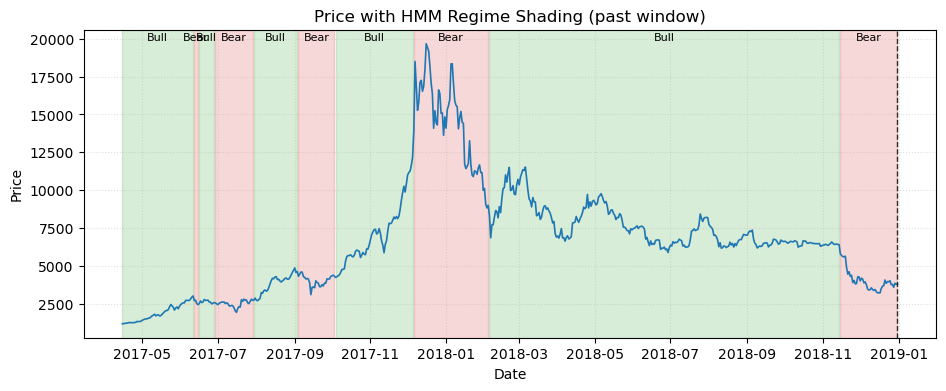

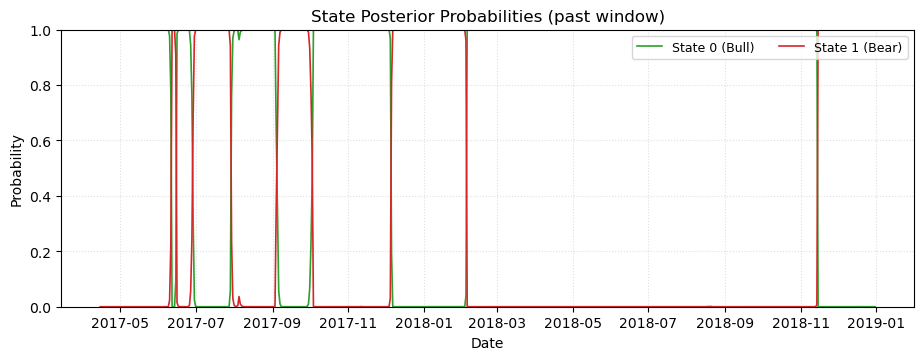

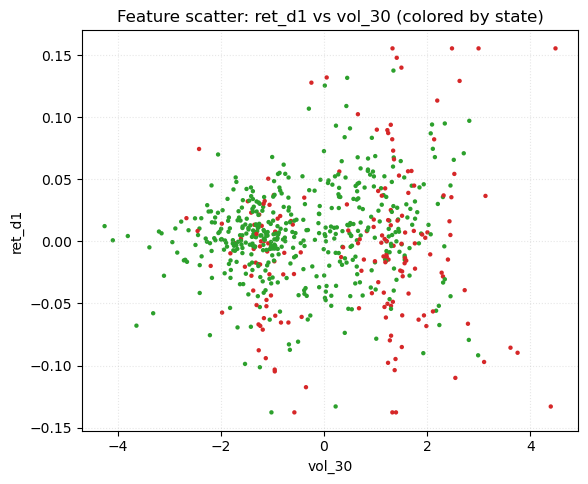

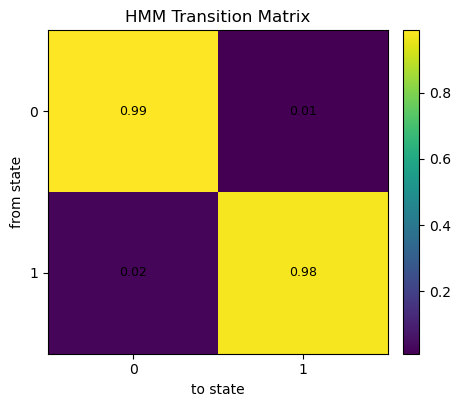

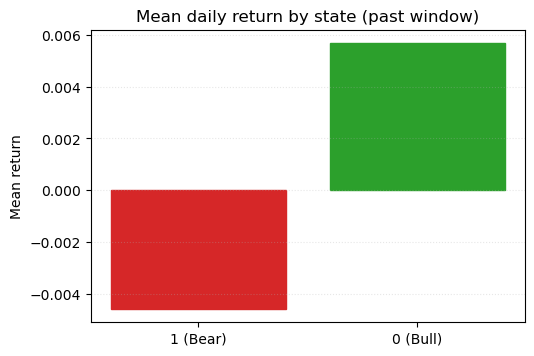

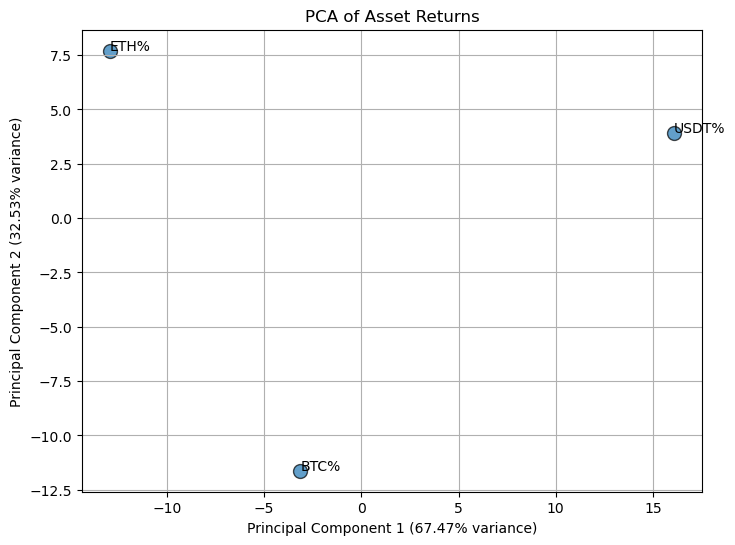

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


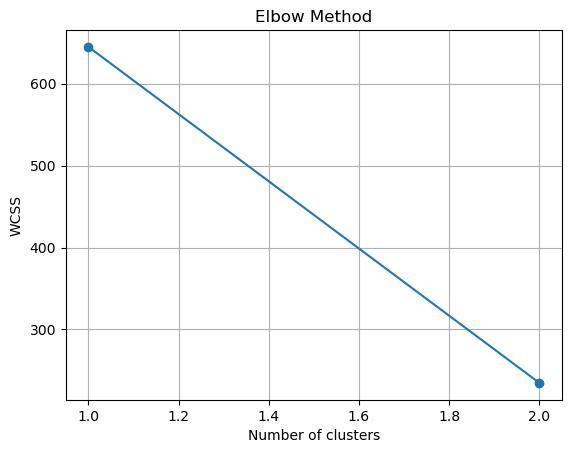

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


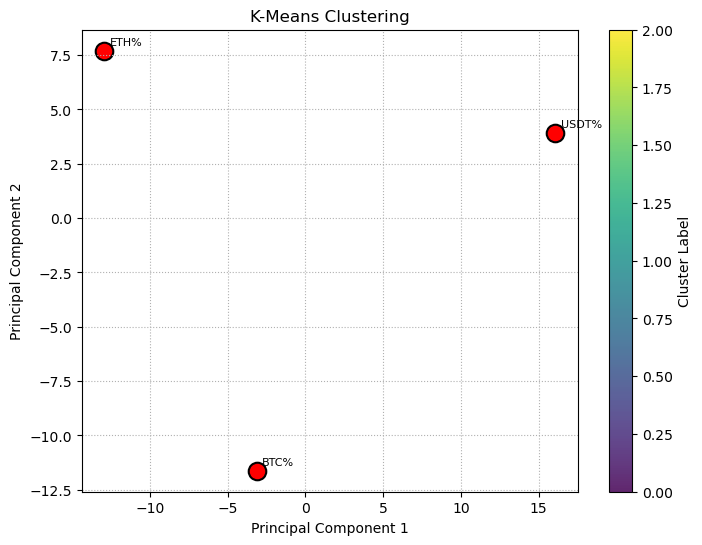

Cluster 0:
 - ETH%

Cluster 1:
 - USDT%

Cluster 2:
 - BTC%

Cluster 0:
 - ETH%

Cluster 1:
 - USDT%

Cluster 2:
 - BTC%

Optimal assets consists of: ['ETH%', 'USDT%', 'BTC%']
['BTC%', 'ETH%', 'USDT%']


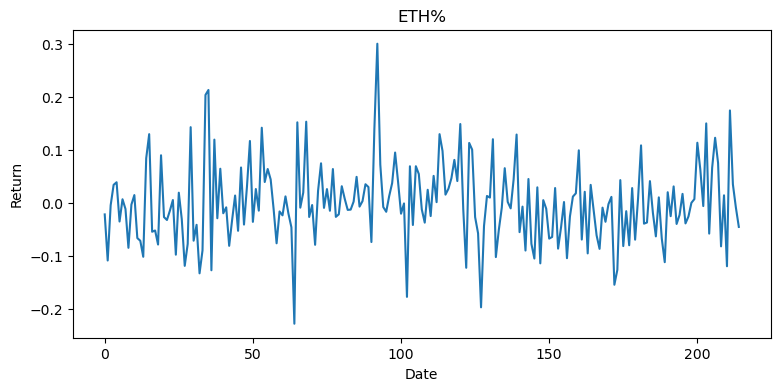

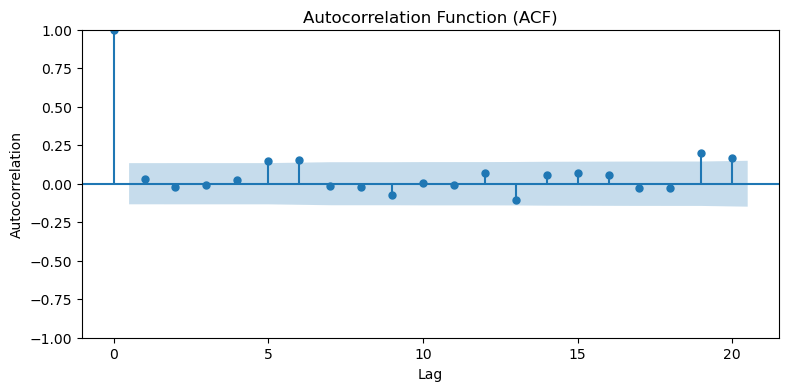

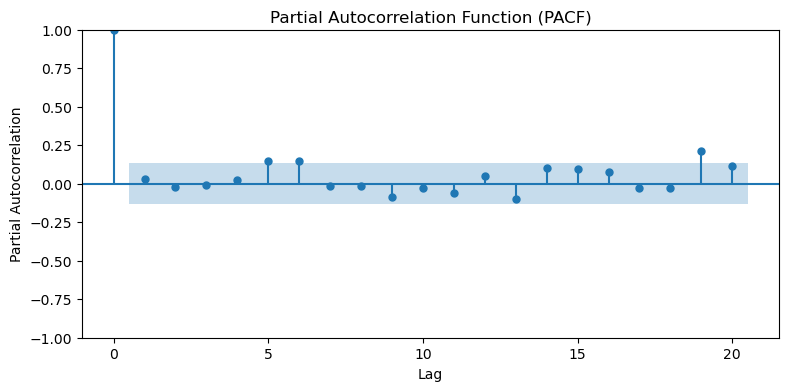

ADF Statistic: -14.116799
p-value: 0.000000
Series is stationary. Proceed with modeling.
AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000274
ma.L1     0.031320
sigma2    0.005607
dtype: float64


C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005613. Parameter
e

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                258.846
Distribution:      Standardized Student's t   AIC:                          -505.692
Method:                  Maximum Likelihood   BIC:                          -485.468
                                              No. Observations:                  215
Date:                      Fri, Oct 03 2025   Df Residuals:                      214
Time:                              17:03:03   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

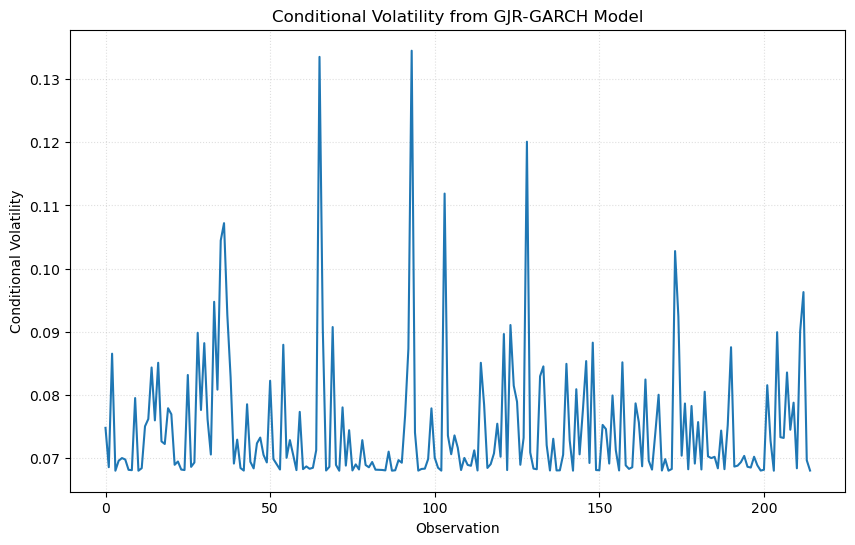

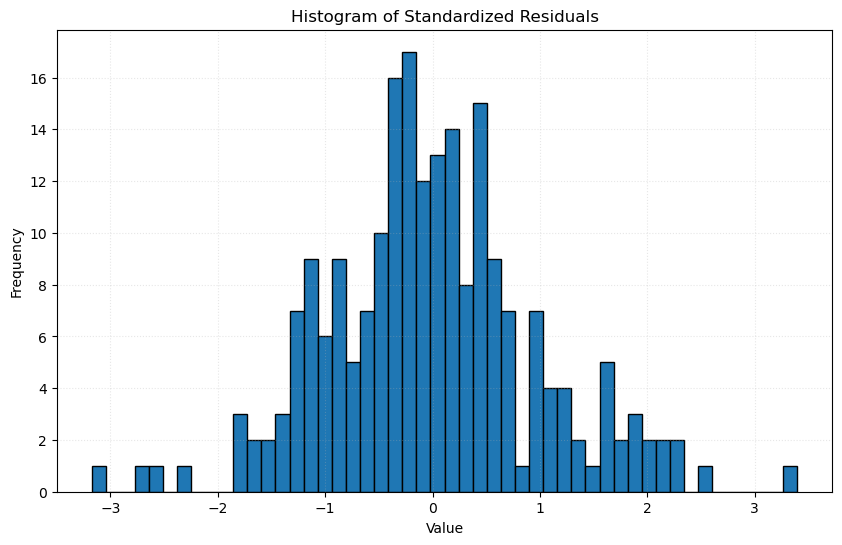

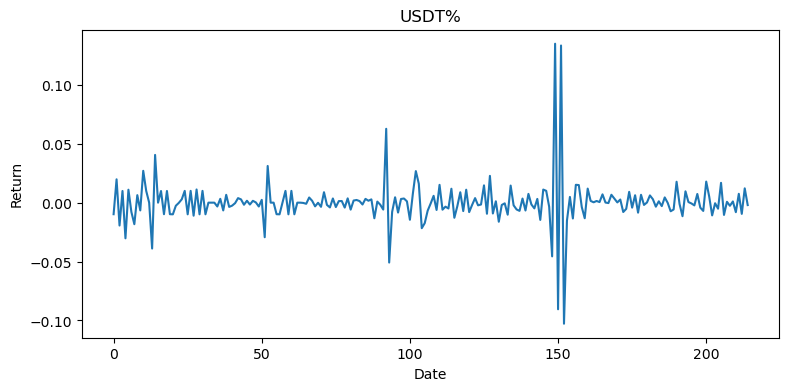

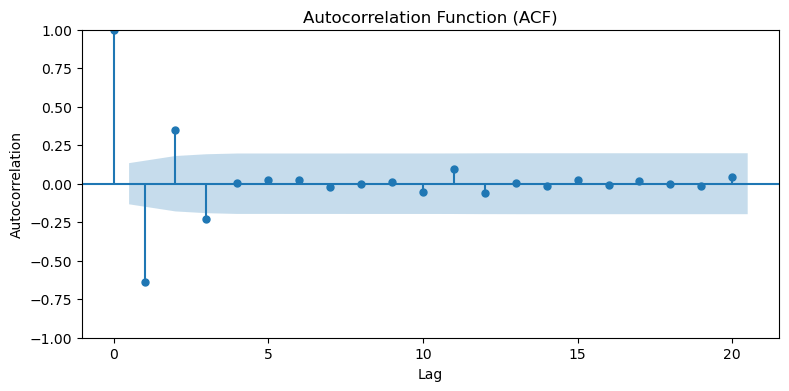

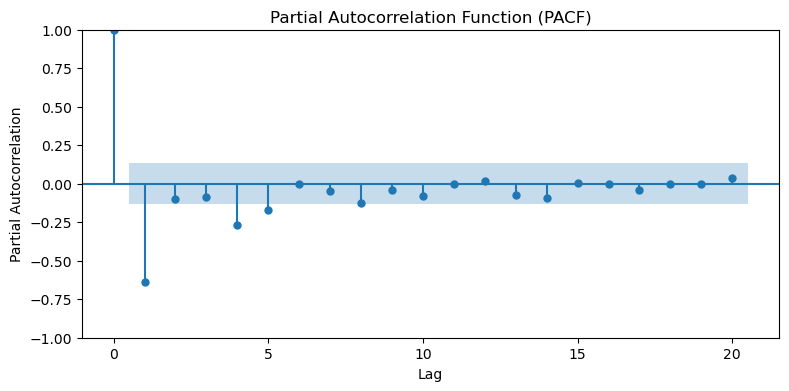

ADF Statistic: -10.748326
p-value: 0.000000
Series is stationary. Proceed with modeling.
AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)


C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003882. Parameter


Coefficients:
const     0.000078
ma.L1    -0.782683
sigma2    0.000227
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                424.960
Distribution:      Standardized Student's t   AIC:                          -837.920
Method:                  Maximum Likelihood   BIC:                          -817.696
                                              No. Observations:                  215
Date:                      Fri, Oct 03 2025   Df Residuals:                      214
Time:                              17:03:05   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Co

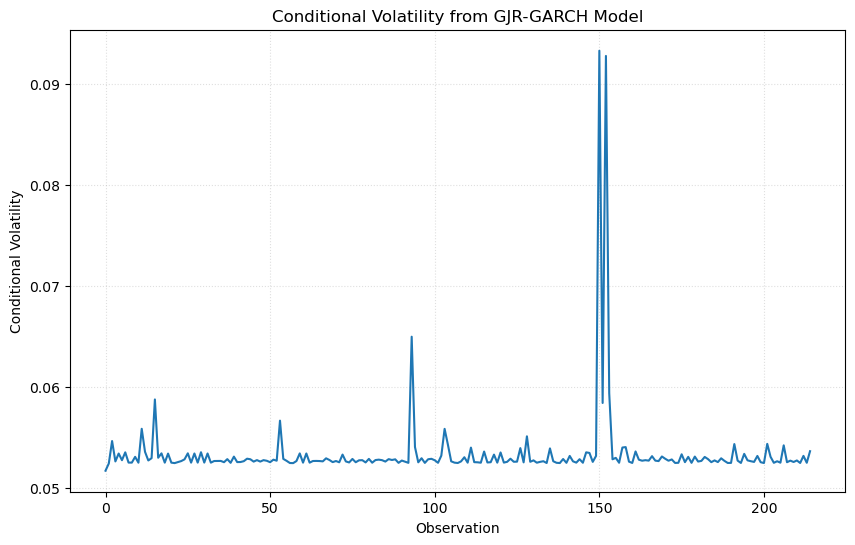

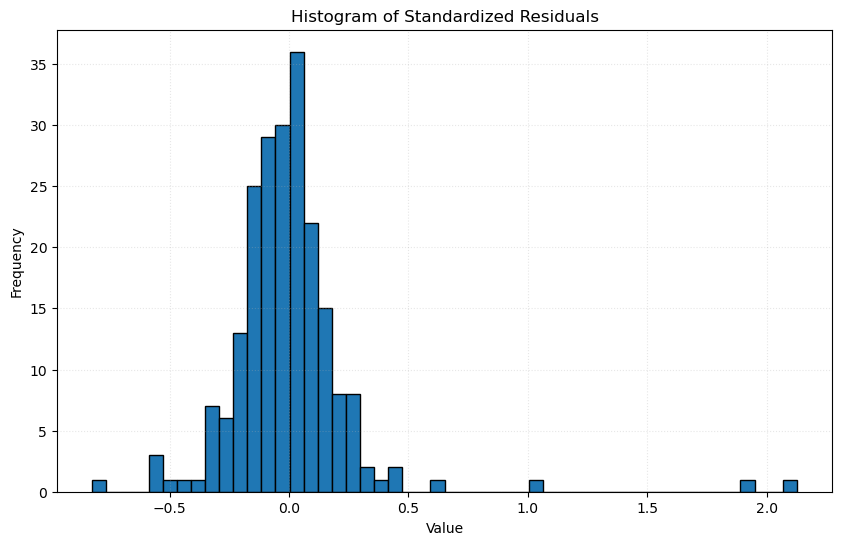

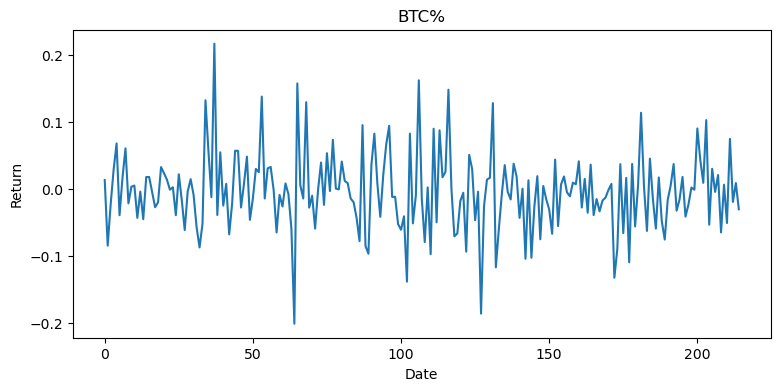

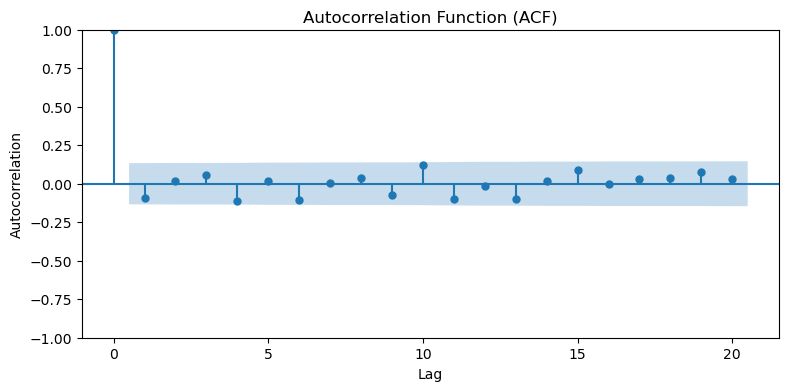

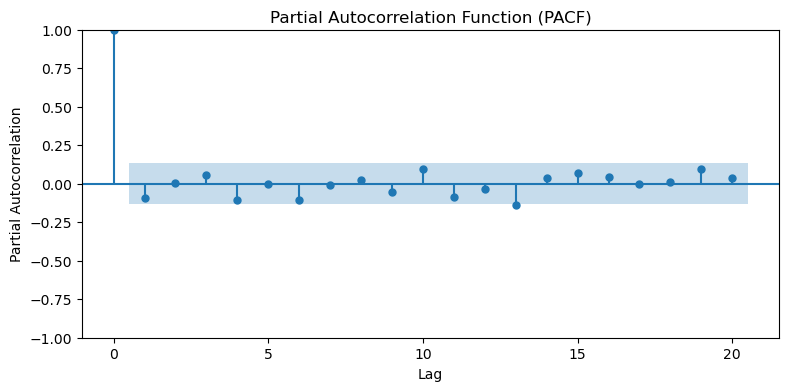

ADF Statistic: -16.009678
p-value: 0.000000
Series is stationary. Proceed with modeling.
AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.004414
ar.L1    -0.094895
sigma2    0.003285
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                322.394
Distribution:      Standardized Student's t   AIC:                          -632.789
Method:                  Maximum Likelihood   BIC:                          -612.565
                                              No. Observations:                  215
Date:                      Fri, Oct 03 2025   Df Residuals:                      214
Time:                              17:03:06   Df Model:                            

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003315. Parameter
e

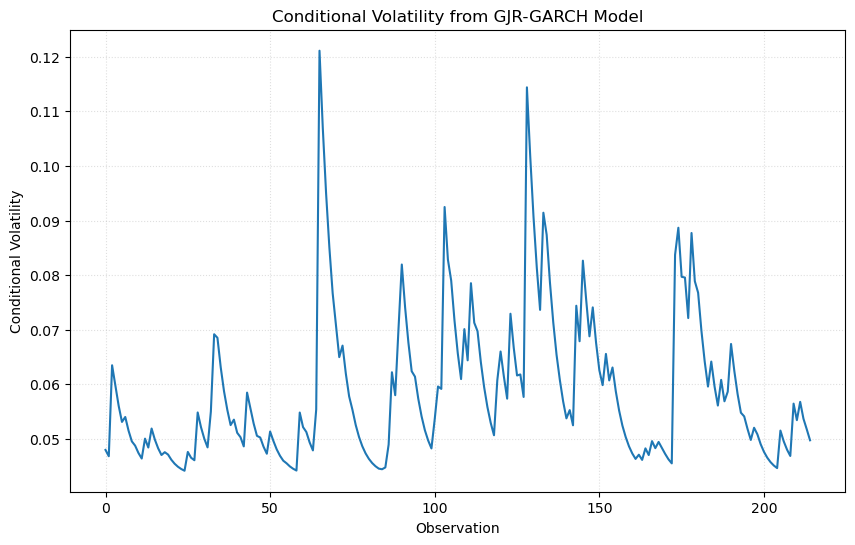

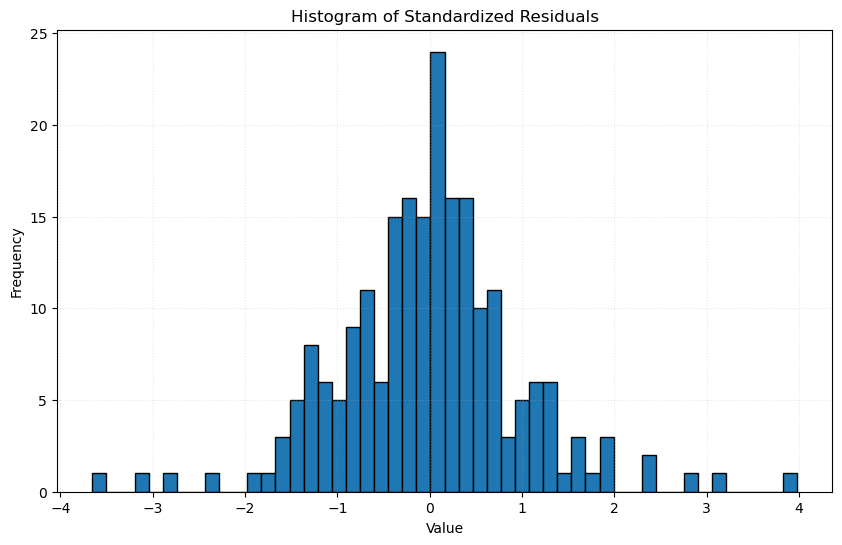

Fitted C-vine copula parameters:
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types       family rotation       parameters  df  tau 
   1    1                  1, 3                             c, c         Tawn      180 0.92, 0.80, 2.86 3.0 0.52 
   1    2                  2, 3                             c, c Independence                               0.00 
   2    1                  1, 2                      3      c, c Independence                               0.00 


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.245050  0.282198  0.073052
1  0.709869  0.518460  0.840174
2  0.953363  0.599939  0.714652
3  0.889784  0.899155  0.948809
4  0.855657  0.319825  0.826308


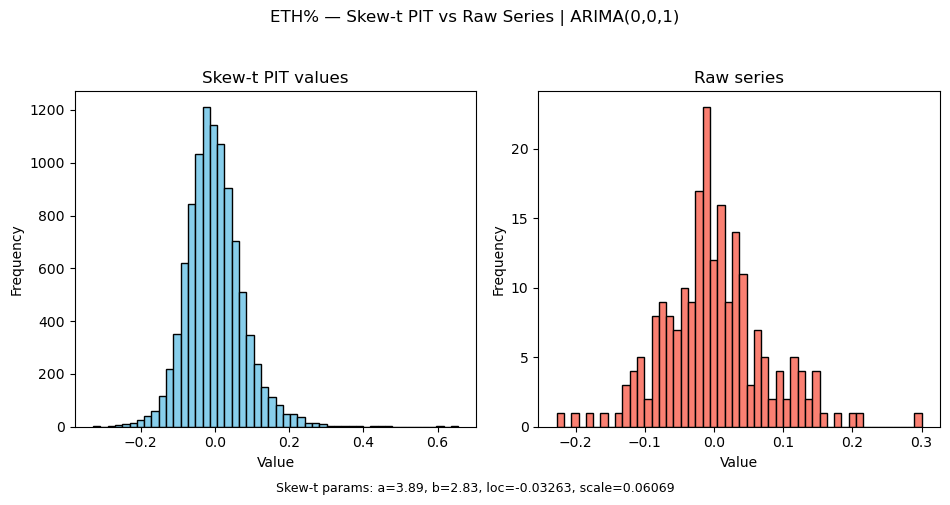

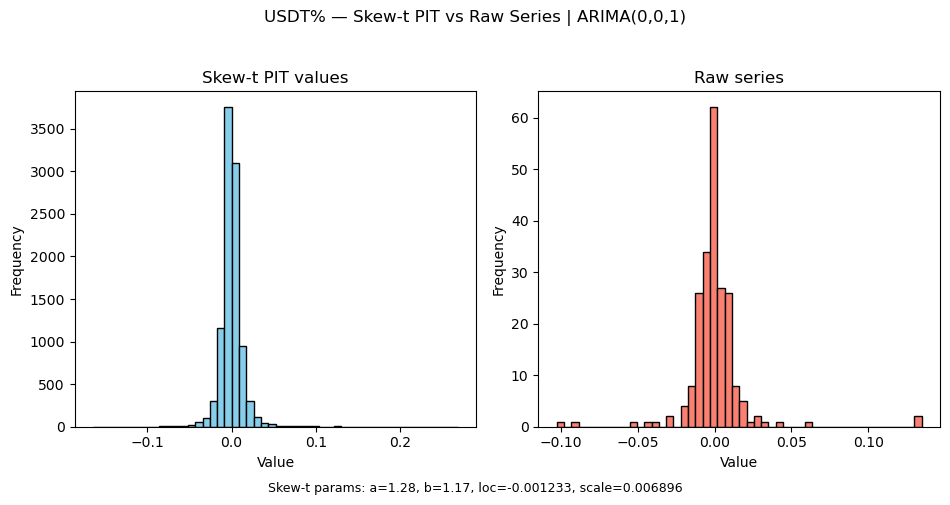

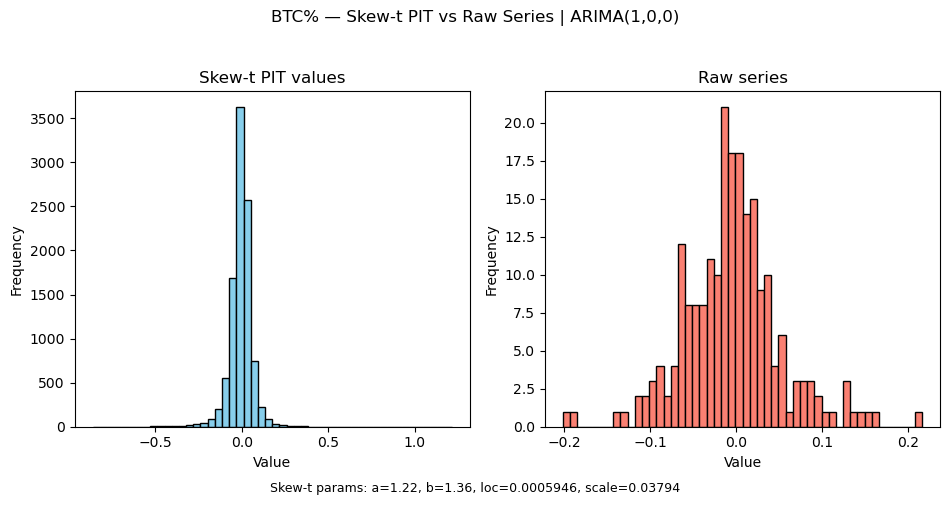

Assets Expected returns = [-0.00099499 -0.00013109 -0.00726206]
Covariance matrix = [[ 5.76310660e-03  4.52633241e-06  3.26703342e-03]
 [ 4.52633241e-06  1.73505996e-04 -1.07197976e-05]
 [ 3.26703342e-03 -1.07197976e-05  4.78217330e-03]]
Portfolio expected return: [-0.00626372 -0.0061211  -0.00597848 -0.00583587 -0.00569325 -0.00555063
 -0.00540801 -0.00526539 -0.00512277 -0.00498015 -0.00483753 -0.00469491
 -0.00455229 -0.00440967 -0.00426705 -0.00412443 -0.00398181 -0.0038392
 -0.00369658 -0.00355396 -0.00341134 -0.00326872 -0.0031261  -0.00298348
 -0.00284086 -0.00269824 -0.00255562 -0.002413   -0.00227038 -0.00212776
 -0.00198514 -0.00184253 -0.00169991 -0.00155729 -0.00141467 -0.00127205
 -0.00112943 -0.00098681 -0.00084419 -0.00070157 -0.00055895 -0.00041633
 -0.00027371 -0.00013109]
Portfolio standard deviation: [0.06412617 0.06313645 0.06215344 0.06117745 0.06020883 0.05924792
 0.05829513 0.05735084 0.05641549 0.05548954 0.05457345 0.05366773
 0.05277294 0.0518896  0.05101832 0

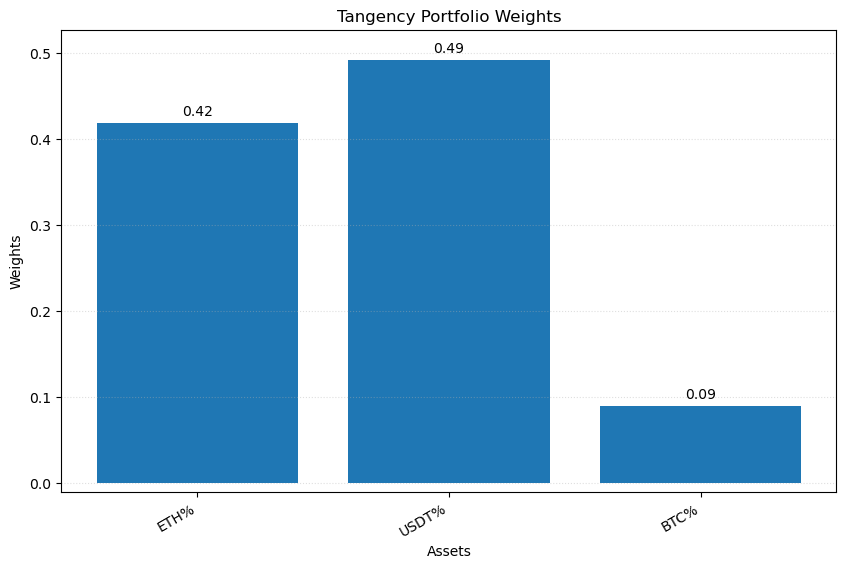

Tangency Portfolio standard deviation: 0.01358269023291537
Expected tangency portfolio return: -0.0001310940602503587


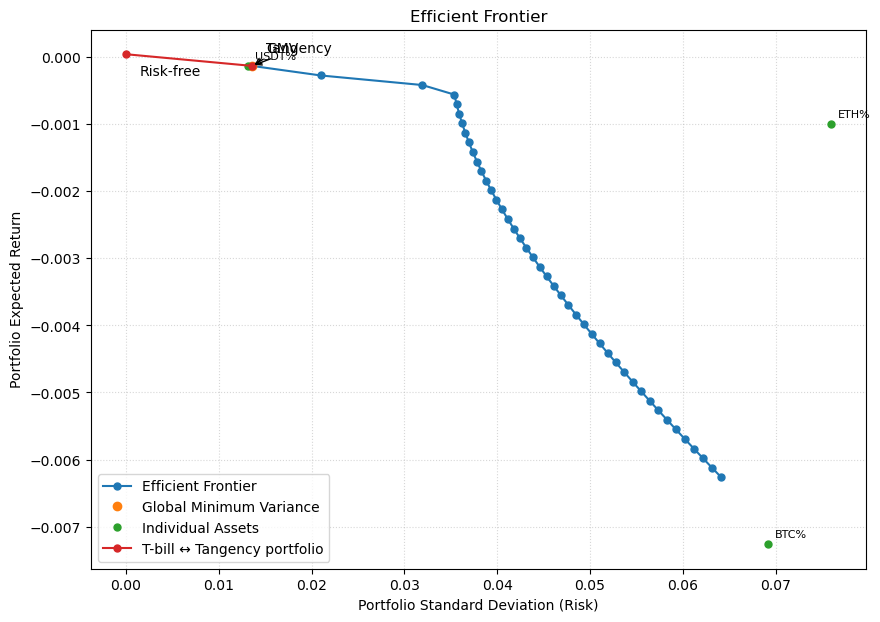

port_sharpe_ratio [-0.34930053 -0.35477608 -0.36038717 -0.36613658 -0.37202691 -0.37806056
 -0.38423972 -0.39056625 -0.39704169 -0.40366716 -0.41044327 -0.41737007
 -0.42444678 -0.43167233 -0.43904428 -0.44655934 -0.45421306 -0.46199972
 -0.46991214 -0.4779415  -0.48607721 -0.49430669 -0.50261521 -0.51098569
 -0.51939852 -0.52783145 -0.53625937 -0.54465427 -0.55298513 -0.56121793
 -0.56931567 -0.57723851 -0.58494398 -0.59238731 -0.59952182 -0.60629945
 -0.61267146 -0.61858908 -0.62400448 -0.62887155 -0.63314727 -0.7015369
 -1.0673344  -1.64910656]
Assets sharpe ratios [-0.26123577 -0.25252544 -2.01827066]
Optimal Portfolio weight: [0.41891227 0.49183747 0.08925026]
Port var95 = -0.055889833168658996
Port cvar95 = -0.07626674802672775
All arrays in weight_array are fully filled.
Iteration no.: 1
Cluster 0:
 - ETH%

Cluster 1:
 - USDT%

Cluster 2:
 - BTC%

Cluster 0:
 - ETH%

Cluster 1:
 - USDT%

Cluster 2:
 - BTC%

Optimal assets consists of: ['ETH%', 'USDT%', 'BTC%']
['BTC%', 'ETH%', '

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.005048
ar.L1    -0.073329
sigma2    0.002753
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                266.712
Distribution:      Standardized Student's t   AIC:                          -521.423
Method:                  Maximum Likelihood   BIC:                          -502.898
                                              No. Observations:                  162
Date:                      Fri, Oct 03 2025   Df Residuals:                      161
Time:                              17:03:12   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.78e-05. Parameter
e

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.003598
ar.L1    -0.066297
sigma2    0.001208
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                344.963
Distribution:      Standardized Student's t   AIC:                          -677.927
Method:                  Maximum Likelihood   BIC:                          -659.401
                                              No. Observations:                  162
Date:                      Fri, Oct 03 2025   Df Residuals:                      161
Time:                              17:03:13   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001213. Parameter
e

Assets Expected returns = [0.00711211 0.00013752 0.00381737]
Covariance matrix = [[ 4.46708814e-03  3.90280884e-06  1.97720980e-03]
 [ 3.90280884e-06  2.13150692e-05 -7.39877298e-07]
 [ 1.97720980e-03 -7.39877298e-07  2.23772066e-03]]
Portfolio expected return: [0.00013752 0.00027701 0.0004165  0.00055599 0.00069548 0.00083498
 0.00097447 0.00111396 0.00125345 0.00139294 0.00153244 0.00167193
 0.00181142 0.00195091 0.0020904  0.0022299  0.00236939 0.00250888
 0.00264837 0.00278786 0.00292736 0.00306685 0.00320634 0.00334583
 0.00348532 0.00362481 0.00376431 0.0039038  0.00404329 0.00418278
 0.00432227 0.00446177 0.00460126 0.00474075 0.00488024 0.00501973
 0.00529872 0.00543821 0.0055777  0.00585669 0.00599618 0.00613567
 0.00641465 0.00655415 0.00669364 0.00683313 0.00697262]
Portfolio standard deviation: [0.00461855 0.00496413 0.00586946 0.00712426 0.00857647 0.01014165
 0.01177473 0.01345113 0.01504833 0.01588093 0.01677559 0.0177257
 0.01872281 0.01975981 0.02083074 0.02193063 0.02

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.005056
ar.L1    -0.157831
sigma2    0.002122
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                317.627
Distribution:      Standardized Student's t   AIC:                          -623.254
Method:                  Maximum Likelihood   BIC:                          -603.965
                                              No. Observations:                  184
Date:                      Fri, Oct 03 2025   Df Residuals:                      183
Time:                              17:03:15   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002174. Parameter
e

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 1)
Coefficients:
const     0.000479
ar.L1    -0.389319
ma.L1    -0.305709
sigma2    0.000062
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                496.956
Distribution:      Standardized Student's t   AIC:                          -981.911
Method:                  Maximum Likelihood   BIC:                          -962.621
                                              No. Observations:                  184
Date:                      Fri, Oct 03 2025   Df Residuals:                      183
Time:                              17:03:15   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.686e-05. Parameter


AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.001750
ar.L1    -0.147246
sigma2    0.001719
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                352.786
Distribution:      Standardized Student's t   AIC:                          -693.573
Method:                  Maximum Likelihood   BIC:                          -674.283
                                              No. Observations:                  184
Date:                      Fri, Oct 03 2025   Df Residuals:                      183
Time:                              17:03:16   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001756. Parameter
e


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.136439  0.946119  0.120329
1  0.699348  0.917813  0.644999
2  0.553414  0.919727  0.415241
3  0.194685  0.343499  0.394704
4  0.077562  0.342812  0.086972
Assets Expected returns = [-0.00588035  0.00014038  0.00189503]
Covariance matrix = [[ 2.75520313e-03 -1.44976078e-06  2.21215405e-03]
 [-1.44976078e-06  2.03123834e-05  1.28421629e-06]
 [ 2.21215405e-03  1.28421629e-06  2.76758901e-03]]
Portfolio expected return: [-5.41382936e-03 -5.25832174e-03 -5.10281412e-03 -4.94730650e-03
 -4.79179888e-03 -4.63629126e-03 -4.48078363e-03 -4.32527601e-03
 -4.16976839e-03 -4.01426077e-03 -3.85875315e-03 -3.70324553e-03
 -3.54773791e-03 -3.39223029e-03 -3.23672266e-03 -3.08121504e-03
 -2.92570742e-03 -2.77019980e-03 -2.61469218e-03 -2.45918456e-03
 -2.30367694e-03 -2.14816932e-03 -1.99266169e-03 -1.83715407e-03
 -1.68164645e-03 -1.52613883e-03 -1.37063121e-03 -1.21512359e-03
 -1.05961597e-03 -9.04108

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.009411
ar.L1    -0.060438
sigma2    0.002358
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                267.769
Distribution:      Standardized Student's t   AIC:                          -523.538
Method:                  Maximum Likelihood   BIC:                          -505.125
                                              No. Observations:                  159
Date:                      Fri, Oct 03 2025   Df Residuals:                      158
Time:                              17:03:18   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00094. Parameter
es

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.002762
ar.L1    -0.066524
sigma2    0.001934
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                285.126
Distribution:      Standardized Student's t   AIC:                          -558.252
Method:                  Maximum Likelihood   BIC:                          -539.839
                                              No. Observations:                  159
Date:                      Fri, Oct 03 2025   Df Residuals:                      158
Time:                              17:03:19   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001943. Parameter
e

Assets Expected returns = [-0.01110949  0.00049516 -0.00405172]
Covariance matrix = [[2.89607458e-03 5.58889554e-07 2.20416647e-03]
 [5.58889554e-07 7.15824985e-05 4.06624741e-07]
 [2.20416647e-03 4.06624741e-07 2.51198934e-03]]
Portfolio expected return: [-9.94902543e-03 -9.71693244e-03 -9.48483944e-03 -9.25274644e-03
 -9.02065344e-03 -8.78856044e-03 -8.55646744e-03 -8.32437444e-03
 -8.09228144e-03 -7.86018845e-03 -7.62809545e-03 -7.39600245e-03
 -7.16390945e-03 -6.93181645e-03 -6.69972345e-03 -6.46763045e-03
 -6.23553745e-03 -6.00344446e-03 -5.77135146e-03 -5.53925846e-03
 -5.30716546e-03 -5.07507246e-03 -4.84297946e-03 -4.61088646e-03
 -4.37879346e-03 -4.14670047e-03 -3.91460747e-03 -3.68251447e-03
 -3.45042147e-03 -3.21832847e-03 -2.98623547e-03 -2.75414247e-03
 -2.52204947e-03 -2.28995648e-03 -2.05786348e-03 -1.82577048e-03
 -1.59367748e-03 -1.36158448e-03 -1.12949148e-03 -8.97398484e-04
 -6.65305485e-04 -4.33212486e-04 -2.01119487e-04  3.09735113e-05
  2.63066510e-04  4.95159509e

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.001543
ar.L1     0.019450
sigma2    0.001247
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                455.123
Distribution:      Standardized Student's t   AIC:                          -898.246
Method:                  Maximum Likelihood   BIC:                          -877.670
                                              No. Observations:                  228
Date:                      Fri, Oct 03 2025   Df Residuals:                      227
Time:                              17:03:21   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001248. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.002518
ma.L1     0.705133
sigma2    0.000185
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                264.063
Distribution:      Standardized Student's t   AIC:                          -516.125
Method:                  Maximum Likelihood   BIC:                          -495.549
                                              No. Observations:                  228
Date:                      Fri, Oct 03 2025   Df Residuals:                      227
Time:                              17:03:22   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007938. Parameter


Fitted C-vine copula parameters:
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types       family rotation parameters  df  tau 
   1    1                  1, 3                             c, c      Student        0 0.82, 4.37 2.0 0.61 
   1    2                  2, 3                             c, c Independence                         0.00 
   2    1                  1, 2                      3      c, c Independence                         0.00 


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.506740  0.259593  0.334432
1  0.411237  0.684169  0.572375
2  0.965919  0.143063  0.973282
3  0.583595  0.540384  0.715877
4  0.689221  0.854513  0.130270
Assets Expected returns = [0.00312001 0.00051351 0.00142842]
Covariance matrix = [[ 2.71874811e-03 -2.68274857e-07  1.35979929e-03]
 [-2.68274857e-07  1.40981642e-05  1.26414557e-06]
 [ 1.35979929e-03  1.26414557e-06  1.3575

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.005003
ar.L1    -0.809992
ma.L1     0.695213
sigma2    0.003210
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                342.751
Distribution:      Standardized Student's t   AIC:                          -673.502
Method:                  Maximum Likelihood   BIC:                          -653.334
                                              No. Observations:                  213
Date:                      Fri, Oct 03 2025   Df Residuals:                      212
Time:                              17:03:24   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003334. Parameter
e

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.000771
ar.L1    -0.707185
ma.L1     0.301532
sigma2    0.000459
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                389.155
Distribution:      Standardized Student's t   AIC:                          -766.310
Method:                  Maximum Likelihood   BIC:                          -746.142
                                              No. Observations:                  213
Date:                      Fri, Oct 03 2025   Df Residuals:                      212
Time:                              17:03:25   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005885. Parameter


AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.002065
ar.L1    -0.855626
ma.L1     0.756144
sigma2    0.002009
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                401.363
Distribution:      Standardized Student's t   AIC:                          -790.726
Method:                  Maximum Likelihood   BIC:                          -770.558
                                              No. Observations:                  213
Date:                      Fri, Oct 03 2025   Df Residuals:                      212
Time:                              17:03:25   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002084. Parameter
e

Fitted C-vine copula parameters:
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types       family rotation parameters  df  tau 
   1    1                  2, 1                             c, c          Joe      180       1.17 1.0 0.09 
   1    2                  1, 3                             c, c       Gumbel      180       2.82 1.0 0.65 
   2    1                  2, 3                      1      c, c Independence                         0.00 


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.066694  0.086330  0.043031
1  0.960913  0.742051  0.760030
2  0.104073  0.240025  0.202420
3  0.227386  0.775303  0.421831
4  0.114883  0.210509  0.084308
Assets Expected returns = [-0.00473318  0.00015405 -0.00148684]
Covariance matrix = [[3.20233824e-03 4.07243828e-05 2.26438215e-03]
 [4.07243828e-05 2.80567361e-05 2.93007468e-05]
 [2.26438215e-03 2.93007468e-05 2.51145639e-

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.002989
ar.L1    -0.167948
sigma2    0.003328
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                318.087
Distribution:      Standardized Student's t   AIC:                          -624.174
Method:                  Maximum Likelihood   BIC:                          -604.629
                                              No. Observations:                  192
Date:                      Fri, Oct 03 2025   Df Residuals:                      191
Time:                              17:03:28   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003425. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.000128
ma.L1    -0.682380
sigma2    0.000014
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -210.191
Distribution:      Standardized Student's t   AIC:                           432.383
Method:                  Maximum Likelihood   BIC:                           451.928
                                              No. Observations:                  192
Date:                      Fri, Oct 03 2025   Df Residuals:                      191
Time:                              17:03:28   Df Model:                            1
                               Mean Model                               
              

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.05e-05. Parameter
e

Fitted C-vine copula parameters:
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types       family rotation parameters  df  tau 
   1    1                  1, 3                             c, c       Gumbel      180       2.98 1.0 0.66 
   1    2                  2, 3                             c, c        Frank        0       1.51 1.0 0.16 
   2    1                  1, 2                      3      c, c Independence                         0.00 


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.587397  0.388269  0.398442
1  0.734992  0.804645  0.650002
2  0.206375  0.428246  0.096432
3  0.186762  0.994485  0.208562
4  0.122174  0.053944  0.071464
Assets Expected returns = [-1.50099977e-03  8.62978289e-05  2.35152664e-04]
Covariance matrix = [[4.55014443e-03 4.37605621e-05 3.32339237e-03]
 [4.37605621e-05 2.15226568e-05 4.25575664e-05]
 [3.32339237e-03 4.25575664e-05 

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

Cluster 0:
 - ETH%

Cluster 1:
 - USDT%

Cluster 2:
 - BTC%

Cluster 0:
 - ETH%

Cluster 1:
 - USDT%

Cluster 2:
 - BTC%

Optimal assets consists of: ['ETH%', 'USDT%', 'BTC%']
['BTC%', 'ETH%', 'USDT%']
ADF Statistic: -14.078099
p-value: 0.000000
Series is stationary. Proceed with modeling.
AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.004544
ma.L1    -0.053405
sigma2    0.001883
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                327.173
Distribution:      Standardized Student's t   AIC:                          -642.345
Method:                  Maximum Likelihood   BIC:                          -623.154
                                              No. O

C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001889. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\L

Coefficients:
const     0.000019
ar.L1    -0.350192
sigma2    0.000004
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -317.846
Distribution:      Standardized Student's t   AIC:                           647.691
Method:                  Maximum Likelihood   BIC:                           666.882
                                              No. Observations:                  181
Date:                      Fri, Oct 03 2025   Df Residuals:                      180
Time:                              17:03:31   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
---

C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.098e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmod

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.004560
ma.L1    -0.170723
sigma2    0.001389
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                353.168
Distribution:      Standardized Student's t   AIC:                          -694.336
Method:                  Maximum Likelihood   BIC:                          -675.145
                                              No. Observations:                  181
Date:                      Fri, Oct 03 2025   Df Residuals:                      180
Time:                              17:03:31   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.005456
ar.L1    -0.013462
sigma2    0.001331
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                427.671
Distribution:      Standardized Student's t   AIC:                          -843.343
Method:                  Maximum Likelihood   BIC:                          -822.981
                                              No. Observations:                  220
Date:                      Fri, Oct 03 2025   Df Residuals:                      219
Time:                              17:03:34   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001331. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000079
ma.L1    -0.529184
sigma2    0.000005
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                14.0508
Distribution:      Standardized Student's t   AIC:                          -16.1017
Method:                  Maximum Likelihood   BIC:                           4.26011
                                              No. Observations:                  220
Date:                      Fri, Oct 03 2025   Df Residuals:                      219
Time:                              17:03:34   Df Model:                            1
                               Mean Model                               
              

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.003102
ar.L1     0.001585
sigma2    0.000772
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                513.078
Distribution:      Standardized Student's t   AIC:                          -1014.16
Method:                  Maximum Likelihood   BIC:                          -993.793
                                              No. Observations:                  220
Date:                      Fri, Oct 03 2025   Df Residuals:                      219
Time:                              17:03:34   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.003185
ar.L1    -0.233101
sigma2    0.003995
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                252.199
Distribution:      Standardized Student's t   AIC:                          -492.399
Method:                  Maximum Likelihood   BIC:                          -473.584
                                              No. Observations:                  170
Date:                      Fri, Oct 03 2025   Df Residuals:                      169
Time:                              17:03:37   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004217. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000108
ma.L1    -0.692888
sigma2    0.000009
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -546.556
Distribution:      Standardized Student's t   AIC:                           1105.11
Method:                  Maximum Likelihood   BIC:                           1123.93
                                              No. Observations:                  170
Date:                      Fri, Oct 03 2025   Df Residuals:                      169
Time:                              17:03:37   Df Model:                            1
                               Mean Model                               
              

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.449e-05. Parameter


AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.003700
ar.L1    -0.827627
ma.L1     0.705726
sigma2    0.002537
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                296.027
Distribution:      Standardized Student's t   AIC:                          -580.054
Method:                  Maximum Likelihood   BIC:                          -561.239
                                              No. Observations:                  170
Date:                      Fri, Oct 03 2025   Df Residuals:                      169
Time:                              17:03:37   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002643. Parameter
e

Fitted C-vine copula parameters:
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types  family rotation  parameters  df   tau 
   1    1                  2, 1                             c, c Student        0 -0.10, 2.39 2.0 -0.06 
   1    2                  1, 3                             c, c  Gumbel      180        2.61 1.0  0.62 
   2    1                  2, 3                      1      c, c Clayton        0        0.25 1.0  0.11 


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.709075  0.588874  0.755817
1  0.707892  0.804008  0.800933
2  0.625674  0.126101  0.764045
3  0.056862  0.151284  0.030505
4  0.876158  0.483117  0.872363
Assets Expected returns = [ 0.00404531 -0.00024306  0.00492448]
Covariance matrix = [[ 3.95572938e-03 -3.18576751e-05  2.66851579e-03]
 [-3.18576751e-05  1.44742910e-05 -3.72178556e-06]
 [ 2.66851579e-03 -3.72178556e-06  2.99442740e-03]

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.006157
ar.L1    -0.030539
sigma2    0.001372
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                437.271
Distribution:      Standardized Student's t   AIC:                          -862.542
Method:                  Maximum Likelihood   BIC:                          -841.966
                                              No. Observations:                  228
Date:                      Fri, Oct 03 2025   Df Residuals:                      227
Time:                              17:03:40   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001373. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000018
ma.L1    -0.722894
sigma2    0.000003
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -268.108
Distribution:      Standardized Student's t   AIC:                           548.217
Method:                  Maximum Likelihood   BIC:                           568.793
                                              No. Observations:                  228
Date:                      Fri, Oct 03 2025   Df Residuals:                      227
Time:                              17:03:40   Df Model:                            1
                               Mean Model                               
              

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008197. Parameter


Fitted C-vine copula parameters:
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types family rotation       parameters  df   tau 
   1    1                  1, 3                             c, c   Tawn      180 0.96, 0.87, 3.31 3.0  0.61 
   1    2                  2, 3                             c, c    Joe       90             1.14 1.0 -0.07 
   2    1                  1, 2                      3      c, c Gumbel        0             1.12 1.0  0.11 


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.546287  0.475329  0.650997
1  0.444440  0.323664  0.548770
2  0.664561  0.921618  0.905808
3  0.115027  0.042437  0.135054
4  0.963397  0.942405  0.828598
Assets Expected returns = [ 7.58199427e-03 -1.98280156e-05  2.55192749e-03]
Covariance matrix = [[ 2.46533088e-03  5.67566732e-07  1.17805403e-03]
 [ 5.67566732e-07  5.06933423e-06 -1.41592734e-05]
 [ 1.17805403e-03 -1.4

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.000366
ar.L1    -0.865508
ma.L1     0.752119
sigma2    0.003564
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                231.309
Distribution:      Standardized Student's t   AIC:                          -450.619
Method:                  Maximum Likelihood   BIC:                          -432.168
                                              No. Observations:                  160
Date:                      Fri, Oct 03 2025   Df Residuals:                      159
Time:                              17:03:43   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003755. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000083
ma.L1    -0.700476
sigma2    0.000007
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -246.610
Distribution:      Standardized Student's t   AIC:                           505.219
Method:                  Maximum Likelihood   BIC:                           523.670
                                              No. Observations:                  160
Date:                      Fri, Oct 03 2025   Df Residuals:                      159
Time:                              17:03:43   Df Model:                            1
                               Mean Model                               
              

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.173e-05. Parameter


AIC selected model = (1, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000866
ar.L1     0.665573
ma.L1    -0.791317
sigma2    0.001612
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                290.665
Distribution:      Standardized Student's t   AIC:                          -569.330
Method:                  Maximum Likelihood   BIC:                          -550.879
                                              No. Observations:                  160
Date:                      Fri, Oct 03 2025   Df Residuals:                      159
Time:                              17:03:43   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001659. Parameter
e

Fitted C-vine copula parameters:
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types       family rotation parameters  df  tau 
   1    1                  2, 1                             c, c          Joe      180       1.25 1.0 0.13 
   1    2                  1, 3                             c, c       Gumbel      180       2.41 1.0 0.59 
   2    1                  2, 3                      1      c, c Independence                         0.00 


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.459643  0.781684  0.722904
1  0.554588  0.293389  0.370838
2  0.623376  0.572830  0.728730
3  0.333604  0.554794  0.619475
4  0.206560  0.770718  0.216564
Assets Expected returns = [ 0.00091881 -0.00024039 -0.00121119]
Covariance matrix = [[3.94953480e-03 7.02450481e-05 2.36764399e-03]
 [7.02450481e-05 7.95048477e-05 5.35868169e-05]
 [2.36764399e-03 5.35868169e-05 2.26623962e-

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 1)
Coefficients:
const     0.004521
ar.L1    -0.927577
ma.L1     0.811582
sigma2    0.003277
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                260.581
Distribution:      Standardized Student's t   AIC:                          -509.161
Method:                  Maximum Likelihood   BIC:                          -490.242
                                              No. Observations:                  173
Date:                      Fri, Oct 03 2025   Df Residuals:                      172
Time:                              17:03:46   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003619. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000018
ma.L1    -0.747536
sigma2    0.000007
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                70.2859
Distribution:      Standardized Student's t   AIC:                          -128.572
Method:                  Maximum Likelihood   BIC:                          -109.652
                                              No. Observations:                  173
Date:                      Fri, Oct 03 2025   Df Residuals:                      172
Time:                              17:03:46   Df Model:                            1
                                 Mean Model                                
           

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.006e-05. Parameter


AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.002095
ar.L1    -0.098002
sigma2    0.001731
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                317.604
Distribution:      Standardized Student's t   AIC:                          -623.208
Method:                  Maximum Likelihood   BIC:                          -604.288
                                              No. Observations:                  173
Date:                      Fri, Oct 03 2025   Df Residuals:                      172
Time:                              17:03:46   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001748. Parameter
e

Assets Expected returns = [ 5.14506362e-03 -4.22842674e-05  3.16768161e-03]
Covariance matrix = [[ 3.63909804e-03 -3.85455063e-07  2.02294099e-03]
 [-3.85455063e-07  2.07181565e-05 -1.96637813e-07]
 [ 2.02294099e-03 -1.96637813e-07  2.39324250e-03]]
Portfolio expected return: [-4.22842674e-05  6.14626904e-05  1.65209648e-04  2.68956606e-04
  3.72703564e-04  4.76450522e-04  5.80197480e-04  6.83944437e-04
  7.87691395e-04  8.91438353e-04  9.95185311e-04  1.09893227e-03
  1.20267923e-03  1.30642618e-03  1.41017314e-03  1.51392010e-03
  1.61766706e-03  1.72141402e-03  1.82516097e-03  1.92890793e-03
  2.03265489e-03  2.13640185e-03  2.24014880e-03  2.34389576e-03
  2.44764272e-03  2.55138968e-03  2.65513664e-03  2.75888359e-03
  2.86263055e-03  2.96637751e-03  3.07012447e-03  3.17387143e-03
  3.27761838e-03  3.38136534e-03  3.48511230e-03  3.58885926e-03
  3.69260621e-03  3.90010013e-03  4.00384709e-03  4.10759405e-03
  4.31508796e-03  4.41883492e-03  4.62632883e-03  4.73007579e-03
  4.8338

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.001697
ar.L1    -0.850630
ma.L1     0.750061
sigma2    0.002884
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                376.763
Distribution:      Standardized Student's t   AIC:                          -741.525
Method:                  Maximum Likelihood   BIC:                          -720.667
                                              No. Observations:                  239
Date:                      Fri, Oct 03 2025   Df Residuals:                      238
Time:                              17:03:49   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002985. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.000041
ma.L1    -0.505535
sigma2    0.000010
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                365.791
Distribution:      Standardized Student's t   AIC:                          -719.581
Method:                  Maximum Likelihood   BIC:                          -698.723
                                              No. Observations:                  239
Date:                      Fri, Oct 03 2025   Df Residuals:                      238
Time:                              17:03:49   Df Model:                            1
                                 Mean Model                                 
          

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001609. Parameter
e

Assets Expected returns = [1.78439912e-03 6.80694717e-05 1.25869660e-03]
Covariance matrix = [[4.59515969e-03 2.95519729e-05 2.22497839e-03]
 [2.95519729e-05 1.48563231e-05 2.12383447e-05]
 [2.22497839e-03 2.12383447e-05 1.86298267e-03]]
Portfolio expected return: [6.80694717e-05 1.02396065e-04 1.36722658e-04 1.71049251e-04
 2.05375844e-04 2.39702437e-04 2.74029030e-04 3.08355623e-04
 3.42682216e-04 3.77008809e-04 4.11335402e-04 4.45661995e-04
 4.79988588e-04 5.14315181e-04 5.48641774e-04 5.82968367e-04
 6.17294960e-04 6.51621553e-04 6.85948146e-04 7.20274739e-04
 7.54601332e-04 7.88927925e-04 8.23254518e-04 8.57581111e-04
 8.91907704e-04 9.26234297e-04 9.60560890e-04 9.94887483e-04
 1.02921408e-03 1.06354067e-03 1.09786726e-03 1.13219386e-03
 1.16652045e-03 1.20084704e-03 1.23517363e-03 1.26950023e-03
 1.33815341e-03 1.37248001e-03 1.44113319e-03 1.47545979e-03
 1.50978638e-03 1.57843956e-03 1.61276616e-03 1.68141934e-03
 1.71574594e-03 1.78439912e-03]
Portfolio standard deviation: [0

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 1)
Coefficients:
const     0.007077
ar.L1    -0.871514
ma.L1     0.781495
sigma2    0.003824
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                290.264
Distribution:      Standardized Student's t   AIC:                          -568.528
Method:                  Maximum Likelihood   BIC:                          -548.620
                                              No. Observations:                  204
Date:                      Fri, Oct 03 2025   Df Residuals:                      203
Time:                              17:03:52   Df Model:                            1
                                 Mean Model                         

C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003958. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\L

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000061
ma.L1    -0.663261
sigma2    0.000008
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -4518.05
Distribution:      Standardized Student's t   AIC:                           9048.10
Method:                  Maximum Likelihood   BIC:                           9068.01
                                              No. Observations:                  204
Date:                      Fri, Oct 03 2025   Df Residuals:                      203
Time:                              17:03:52   Df Model:                            1
                                 Mean Model                                 
          

C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.172e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodel

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.005439
ar.L1    -0.824480
ma.L1     0.731296
sigma2    0.002004
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                350.041
Distribution:      Standardized Student's t   AIC:                          -688.083
Method:                  Maximum Likelihood   BIC:                          -668.174
                                              No. Observations:                  204
Date:                      Fri, Oct 03 2025   Df Residuals:                      203
Time:                              17:03:53   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 1)
Coefficients:
const     0.001852
ar.L1    -0.913112
ma.L1     0.798792
sigma2    0.003734
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                228.244
Distribution:      Standardized Student's t   AIC:                          -444.489
Method:                  Maximum Likelihood   BIC:                          -426.038
                                              No. Observations:                  160
Date:                      Fri, Oct 03 2025   Df Residuals:                      159
Time:                              17:03:55   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00403. Parameter
es

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000093
ma.L1    -0.632316
sigma2    0.000005
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1444.98
Distribution:      Standardized Student's t   AIC:                           2901.95
Method:                  Maximum Likelihood   BIC:                           2920.40
                                              No. Observations:                  160
Date:                      Fri, Oct 03 2025   Df Residuals:                      159
Time:                              17:03:55   Df Model:                            1
                               Mean Model                               
              

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.001655
ar.L1    -0.794815
ma.L1     0.658516
sigma2    0.001817
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                281.941
Distribution:      Standardized Student's t   AIC:                          -551.881
Method:                  Maximum Likelihood   BIC:                          -533.430
                                              No. Observations:                  160
Date:                      Fri, Oct 03 2025   Df Residuals:                      159
Time:                              17:03:56   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Assets Expected returns = [ 0.00196679 -0.00010984 -0.00192852]
Covariance matrix = [[3.93504963e-03 2.07948918e-07 2.37958161e-03]
 [2.07948918e-07 1.21009932e-05 5.74601268e-07]
 [2.37958161e-03 5.74601268e-07 2.23240375e-03]]
Portfolio expected return: [-1.85061070e-03 -1.77270459e-03 -1.69479847e-03 -1.61689235e-03
 -1.53898624e-03 -1.46108012e-03 -1.38317400e-03 -1.30526789e-03
 -1.22736177e-03 -1.14945565e-03 -1.07154954e-03 -9.93643420e-04
 -9.15737303e-04 -8.37831186e-04 -7.59925070e-04 -6.82018953e-04
 -6.04112836e-04 -5.26206719e-04 -4.48300602e-04 -3.70394485e-04
 -2.92488369e-04 -2.14582252e-04 -1.36676135e-04 -5.87700182e-05
  1.91360986e-05  9.70422154e-05  1.74948332e-04  2.52854449e-04
  3.30760566e-04  4.08666683e-04  4.86572799e-04  5.64478916e-04
  6.42385033e-04  7.20291150e-04  7.98197267e-04  8.76103383e-04
  9.54009500e-04  1.03191562e-03  1.10982173e-03  1.18772785e-03
  1.26563397e-03  1.34354008e-03  1.42144620e-03  1.49935232e-03
  1.57725843e-03  1.81097679e

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.001029
ar.L1    -0.836369
ma.L1     0.707063
sigma2    0.003528
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                268.900
Distribution:      Standardized Student's t   AIC:                          -525.799
Method:                  Maximum Likelihood   BIC:                          -506.542
                                              No. Observations:                  183
Date:                      Fri, Oct 03 2025   Df Residuals:                      182
Time:                              17:03:58   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003729. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.000065
ma.L1    -0.642031
sigma2    0.000006
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                833.051
Distribution:      Standardized Student's t   AIC:                          -1654.10
Method:                  Maximum Likelihood   BIC:                          -1634.84
                                              No. Observations:                  183
Date:                      Fri, Oct 03 2025   Df Residuals:                      182
Time:                              17:03:59   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001793. Parameter
e

Assets Expected returns = [-0.00087699  0.00013376 -0.00348574]
Covariance matrix = [[3.76469327e-03 3.51358087e-05 2.39602887e-03]
 [3.51358087e-05 1.74480804e-05 2.83394488e-05]
 [2.39602887e-03 2.83394488e-05 2.23924666e-03]]
Portfolio expected return: [-3.26856862e-03 -3.19617867e-03 -3.12378872e-03 -3.05139876e-03
 -2.97900881e-03 -2.90661886e-03 -2.83422890e-03 -2.76183895e-03
 -2.68944899e-03 -2.61705904e-03 -2.54466909e-03 -2.47227913e-03
 -2.39988918e-03 -2.32749923e-03 -2.25510927e-03 -2.18271932e-03
 -2.11032937e-03 -2.03793941e-03 -1.96554946e-03 -1.89315951e-03
 -1.82076955e-03 -1.74837960e-03 -1.67598965e-03 -1.60359969e-03
 -1.53120974e-03 -1.45881978e-03 -1.38642983e-03 -1.31403988e-03
 -1.24164992e-03 -1.16925997e-03 -1.09687002e-03 -1.02448006e-03
 -9.52090110e-04 -8.79700157e-04 -8.07310203e-04 -7.34920250e-04
 -6.62530296e-04 -5.90140343e-04 -5.17750389e-04 -4.45360436e-04
 -3.72970482e-04 -3.00580529e-04 -2.28190575e-04 -1.55800622e-04
 -8.34106681e-05 -1.10207145e

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.006035
ma.L1    -0.017628
sigma2    0.001674
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                400.802
Distribution:      Standardized Student's t   AIC:                          -789.604
Method:                  Maximum Likelihood   BIC:                          -769.242
                                              No. Observations:                  220
Date:                      Fri, Oct 03 2025   Df Residuals:                      219
Time:                              17:04:01   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users

AIC selected model = (1, 0, 1)
BIC selected model = (1, 0, 1)
Coefficients:
const    -0.000074
ar.L1     0.184324
ma.L1    -0.725673
sigma2    0.000004
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -407.541
Distribution:      Standardized Student's t   AIC:                           827.082
Method:                  Maximum Likelihood   BIC:                           847.444
                                              No. Observations:                  220
Date:                      Fri, Oct 03 2025   Df Residuals:                      219
Time:                              17:04:02   Df Model:                            1
                               Mean Model                           

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.005617
ma.L1     0.014686
sigma2    0.001104
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                445.906
Distribution:      Standardized Student's t   AIC:                          -879.811
Method:                  Maximum Likelihood   BIC:                          -859.449
                                              No. Observations:                  220
Date:                      Fri, Oct 03 2025   Df Residuals:                      219
Time:                              17:04:02   Df Model:                            1
                                  Mean Model                                 
         

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.003302
ar.L1     0.950109
ma.L1    -0.998311
sigma2    0.001333
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                413.568
Distribution:      Standardized Student's t   AIC:                          -815.136
Method:                  Maximum Likelihood   BIC:                          -794.996
                                              No. Observations:                  212
Date:                      Fri, Oct 03 2025   Df Residuals:                      211
Time:                              17:04:05   Df Model:                            1
                                  Mean Model                        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: Converge

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const    -0.000073
ma.L1    -0.335500
sigma2    0.000002
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                502.195
Distribution:      Standardized Student's t   AIC:                          -992.391
Method:                  Maximum Likelihood   BIC:                          -972.251
                                              No. Observations:                  212
Date:                      Fri, Oct 03 2025   Df Residuals:                      211
Time:                              17:04:05   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users

Coefficients:
const     0.002925
ma.L1    -0.012817
sigma2    0.000847
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                464.148
Distribution:      Standardized Student's t   AIC:                          -916.296
Method:                  Maximum Likelihood   BIC:                          -896.157
                                              No. Observations:                  212
Date:                      Fri, Oct 03 2025   Df Residuals:                      211
Time:                              17:04:05   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf

C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008475. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Assets Expected returns = [ 3.62035333e-03 -8.77611010e-05  3.61213338e-03]
Covariance matrix = [[1.74729805e-03 4.55644304e-07 1.08835481e-03]
 [4.55644304e-07 2.58985947e-06 1.52506717e-07]
 [1.08835481e-03 1.52506717e-07 1.18251176e-03]]
Portfolio expected return: [-8.77611010e-05 -1.35988122e-05  6.05634765e-05  1.34725765e-04
  2.08888054e-04  2.83050343e-04  3.57212631e-04  4.31374920e-04
  5.05537209e-04  5.79699497e-04  6.53861786e-04  7.28024075e-04
  8.02186364e-04  8.76348652e-04  9.50510941e-04  1.02467323e-03
  1.09883552e-03  1.17299781e-03  1.24716010e-03  1.32132238e-03
  1.39548467e-03  1.46964696e-03  1.54380925e-03  1.61797154e-03
  1.69213383e-03  1.76629612e-03  1.84045841e-03  1.91462069e-03
  1.98878298e-03  2.06294527e-03  2.13710756e-03  2.21126985e-03
  2.28543214e-03  2.35959443e-03  2.43375672e-03  2.50791900e-03
  2.58208129e-03  2.65624358e-03  2.73040587e-03  2.80456816e-03
  2.87873045e-03  2.95289274e-03  3.02705502e-03  3.10121731e-03
  3.17537960e-03 

C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Panuruj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const     0.000789
ar.L1    -0.097493
sigma2    0.002241
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                330.749
Distribution:      Standardized Student's t   AIC:                          -649.498
Method:                  Maximum Likelihood   BIC:                          -630.016
                                              No. Observations:                  190
Date:                      Fri, Oct 03 2025   Df Residuals:                      189
Time:                              17:04:07   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002263. Parameter
e

AIC selected model = (0, 0, 1)
BIC selected model = (0, 0, 1)
Coefficients:
const     0.000064
ma.L1    -0.609010
sigma2    0.000002
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2455.96
Distribution:      Standardized Student's t   AIC:                           4923.91
Method:                  Maximum Likelihood   BIC:                           4943.40
                                              No. Observations:                  190
Date:                      Fri, Oct 03 2025   Df Residuals:                      189
Time:                              17:04:08   Df Model:                            1
                               Mean Model                               
              

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.028e-06. Parameter


AIC selected model = (1, 0, 0)
BIC selected model = (1, 0, 0)
Coefficients:
const    -0.000146
ar.L1    -0.080773
sigma2    0.001207
dtype: float64
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                391.765
Distribution:      Standardized Student's t   AIC:                          -771.529
Method:                  Maximum Likelihood   BIC:                          -752.047
                                              No. Observations:                  190
Date:                      Fri, Oct 03 2025   Df Residuals:                      189
Time:                              17:04:08   Df Model:                            1
                                  Mean Model                                  
        

C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panuruj\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001215. Parameter
e

Fitted C-vine copula parameters:
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types  family rotation  parameters  df   tau 
   1    1                  2, 1                             c, c Student        0 -0.05, 3.07 2.0 -0.03 
   1    2                  1, 3                             c, c  Gumbel      180        3.50 1.0  0.71 
   2    1                  2, 3                      1      c, c  Gumbel        0        1.11 1.0  0.10 


Simulated data (uniform marginals):
['ETH%', 'USDT%', 'BTC%']
       ETH%     USDT%      BTC%
0  0.470722  0.685536  0.529422
1  0.780834  0.742304  0.881632
2  0.789357  0.509281  0.921240
3  0.561157  0.974228  0.965842
4  0.049879  0.069443  0.012269
Assets Expected returns = [ 1.00244273e-03  4.92895762e-05 -2.43296875e-04]
Covariance matrix = [[ 2.76239012e-03 -6.15502833e-06  1.65030201e-03]
 [-6.15502833e-06  3.82294614e-06  2.74680470e-07]
 [ 1.65030201e-03  2.74680470e-07  1.5

In [3]:
data_all = data0.sort_index().copy()   # <- this is the canonical dataset
data_all = ensure_price_column(data_all, ret_col="BTC%", px_col="BTC"); k = 3
total_port_r = []; total_port_std = []; weight_array = np.empty((0, k));optimal_assets_array_os = np.empty((0, k)); iter_no = 0
port_ret_segments = []; total_port_r = pd.Series(dtype=float)   # timestamped portfolio returns

for t in range(df_rolling_windows.shape[0]-1):
    # window bounds
    # --- window bounds ---
    win_start = df_rolling_windows.loc[t, "Start Date"]
    win_end   = df_rolling_windows.loc[t, "End Date"]
    day_diff = (win_end - win_start).days
    # --- fit HMM on past-only data; two states only ---
    res = fit_hmm_past_window(
        data_all=data_all,
        px_col="BTC",
        win_end=win_end,
        lookback_days=day_diff,
        n_states=3,           # <— TWO regimes
        random_state=42
    )
    if res is None:
        continue  # not enough history

    # states time series over the training window
    series_states = pd.Series(res["states"], index=res["feats"].index, name="state")
    
    # map IDs (already sorted by mean return inside your function)
    bull_id = res["bull_state"]
    bear_id = res["bear_state"]
    sig     = res["sig"]        # +1 => bull, -1 => bear (no neutral)
    
    # restrict states to current window
    S_win = series_states.loc[(series_states.index >= win_start) & (series_states.index <= win_end)]
    
    # choose timestamps for the ACTIVE regime
    idx_regime = S_win.index[S_win == (bull_id if sig == 1 else bear_id)]
    
    # fallback: if empty (edge cases), use full window
    if len(idx_regime) == 0:
        idx_regime = data_all.index[(data_all.index >= win_start) & (data_all.index <= win_end)]
    
    # 1) `data` = regime-reindexed dataset (ALL columns at selected timestamps)
    data = data_all.loc[idx_regime].copy()
    
    # 2) `df` = regime-reindexed subset with your columns
    new_col = ['BTC%', 'ETH%', 'USDT%'] #'XRP%', 'DOGE%'
    # 'DASH%', 'AUR%', 'GRC%', 'ITC%', 'MZC%', 'NMC%', 'NXT%', 'PPC%', 'VTC%', 'XLM%', 'XMR%','XPM%', 'XVG%'
    df = data.loc[:, new_col].copy()
    # Optional: diagnostics (do once to avoid tons of charts)
    if iter_no == 0:
        plot_regime_diagnostics(
            data_all, px_col="BTC",
            win_end=win_end, lookback_days=day_diff, n_states=2
        )
    # If you still want to condition the *training rows* on regime inside the window:
    # Build a within-window mask by re-running a *daily* HMM on the subwindow (optional, advanced).
    # Otherwise, keep df as-is to prevent selection bias.

    # ... continue with your PCA/ARIMA/GARCH/Copula fit on df, then OOS trade on [t1,t2]
    
    risk_free = 0.00004300412
    desc_stats = np.zeros((9,df.shape[1]))
    for i in range(df.shape[1]):
        desc_stats[0,i] = np.mean(df.iloc[:,i]) # expectation
        desc_stats[1,i] = np.std(df.iloc[:,i], ddof=1)  # unbiased standard deviation
        desc_stats[2,i] = np.min(df.iloc[:,i]) # min
        desc_stats[3,i] = np.max(df.iloc[:,i]) # max
        desc_stats[4,i] = np.sum(df.iloc[:,i]) # sum
        desc_stats[5,i] = kurtosis(df.iloc[:,i]) # kurtosis
        desc_stats[6,i] = skew(df.iloc[:,i]) # skewness
        desc_stats[7,i] = jarque_bera(df.iloc[:,i])[0] #JB
        desc_stats[8,i] = (np.mean(df.iloc[:,i]) - risk_free) * np.sqrt(365)/(np.std(df.iloc[:,i], ddof=1)) # Sharpe-ratio

    # desc_stats = np.nan_to_num(desc_stats, nan=0.0).T
    # Create DataFrame to display the results
    # Step 1: Standardize the Data
    def standardize_data(data):
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(data)
        return standardized_data


    # Step 2 and 3: Calculate the Covariance Matrix and Compute Eigenvalues and Eigenvectors
    # These steps are handled internally by PCA in sklearn

    # Step 4 and 5: Sort Eigenvalues and Eigenvectors, and Form Principal Components
    def compute_pca(data, n_components=None):
        standardized_data = standardize_data(data)
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(standardized_data)
        explained_variance_ratio = pca.explained_variance_ratio_
        return principal_components, explained_variance_ratio

    df = df.T
    # Standardize the data
    scaled_data = standardize_data(df)

    # Perform PCA
    principal_components, explained_variance_ratio = compute_pca(df, n_components=2)

    # === Build a DataFrame for plotting/annotation ===
    # principal_components shape should be (n_assets, 2)
    assert principal_components.shape[0] == len(new_col), \
        f"len(new_col)={len(new_col)} must match principal_components rows={principal_components.shape[0]}"
    
    pca_df = pd.DataFrame(principal_components, columns=["PC1", "PC2"], index=new_col)

    
    # --- PCA scatter (saved with title) ---
    if iter_no == 0:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(pca_df["PC1"], pca_df["PC2"], edgecolor="k", s=100, alpha=0.7)
        ax.set_title("PCA of Asset Returns")
        ax.set_xlabel(f"Principal Component 1 ({explained_variance_ratio[0]*100:.2f}% variance)")
        ax.set_ylabel(f"Principal Component 2 ({explained_variance_ratio[1]*100:.2f}% variance)")
        ax.grid(True)
        
        for lbl, x, y in zip(pca_df.index, pca_df["PC1"], pca_df["PC2"]):
            ax.annotate(lbl, (x, y))
    
        title = ax.get_title()
        fname = _safe_name(title, fallback="plot")
        filepath = _unique_path(outdir, fname, ext=".png")
        fig.savefig(filepath, dpi=300, bbox_inches="tight")
        plt.show()
    
    # === Pick nearest/farthest around a reference (use USDT% explicitly) ===
    if sig != 0:
        ref = "USDT%"
        if ref not in pca_df.index:
            raise ValueError(f"{ref} not found in new_col/index")
    
        ref_vec = pca_df.loc[ref, ["PC1", "PC2"]].to_numpy()
        dists = np.linalg.norm(pca_df[["PC1", "PC2"]].to_numpy() - ref_vec, axis=1)
    
        order = np.argsort(dists)
        nearest_idx  = order[:k]
        farthest_idx = order[-k:]
    
        nearest_assets  = pca_df.index[nearest_idx].tolist()
        farthest_assets = pca_df.index[farthest_idx].tolist()
    
        optimal_assets_array = farthest_assets
    
    # === Elbow method (avoid reusing `i`) ===
    wcss = []
    for kk in range(1, len(new_col)):
        km = KMeans(n_clusters=kk, init="k-means++", random_state=42)
        km.fit(pca_df[["PC1", "PC2"]].to_numpy())
        wcss.append(km.inertia_)
    if iter_no == 0:
        fig, ax = plt.subplots()
        ax.plot(range(1, len(new_col)), wcss, marker="o")
        ax.set_title("Elbow Method")
        ax.set_xlabel("Number of clusters")
        ax.set_ylabel("WCSS")
        ax.grid(True)
        title = ax.get_title()
        fname = _safe_name(title, fallback="plot")
        filepath = _unique_path(outdir, fname, ext=".png")
        fig.savefig(filepath, dpi=300, bbox_inches="tight")
        plt.show()
    
    # === KMeans with k=3 ===
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(pca_df[["PC1", "PC2"]].to_numpy())
    if iter_no == 0:
        fig, ax = plt.subplots(figsize=(8, 6))
        sc = ax.scatter(
            pca_df["PC1"], pca_df["PC2"],
            c=kmeans.labels_, cmap="viridis",
            s=60, alpha=0.85, edgecolor="k"
        )
        ax.scatter(
            kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            marker="o", c="red", s=160, linewidths=1.5, edgecolor="k", label="Centroid"
        )
        
        ax.set_title("K-Means Clustering")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.grid(True, linestyle=":")
        
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label("Cluster Label")
        
        for lbl, x, y in zip(pca_df.index, pca_df["PC1"], pca_df["PC2"]):
            ax.annotate(lbl, (x, y), fontsize=8, xytext=(4, 4), textcoords="offset points")
            
        title = ax.get_title()
        fname = _safe_name(title, fallback="plot")
        filepath = _unique_path(outdir, fname, ext=".png")
        fig.savefig(filepath, dpi=300, bbox_inches="tight")
        plt.show()
    
    # If you need the clusters as a dict of names:
    clusters = {c: [] for c in range(k)}
    for name, lab in zip(pca_df.index.tolist(), kmeans.labels_):
        clusters[lab].append(name)
    for c, names in clusters.items():
        print(f"Cluster {c}:")
        for nm in names:
            print(" -", nm)
        print()
 
    # Print out the name of assets in each group separately
    clusters = kmeans.labels_
    asset_clusters = {i: [] for i in range(k)}
    for asset_name, cluster in zip(new_col, clusters):
        asset_clusters[cluster].append(asset_name)

    for cluster, assets in asset_clusters.items():
        print(f"Cluster {cluster}:")
        for asset in assets:
            print(f" - {asset}")
        print()  # Add a blank line between clusters

    # Dictionary to store the optimal asset in each cluster
    optimal_assets = {}
    data_sharpe = desc_stats[desc_stats.shape[0]-1,:]
    new_col = np.array(new_col).T
    # Iterate over each cluster
    for cluster, assets in asset_clusters.items():
        # Compute the Sharpe ratio for each asset within the cluster
        asset_sharpe_ratios = {}
        for asset in assets:
            # Find the row index of the asset
            col_index = np.where(new_col == asset)
            sharpe_ratio = data_sharpe[col_index]
            asset_sharpe_ratios[asset] = sharpe_ratio

        # Choose the asset with the highest Sharpe ratio within the cluster
        optimal_asset = max(asset_sharpe_ratios, key=asset_sharpe_ratios.get)
        optimal_assets[cluster] = optimal_asset
    optimal_assets_array = np.array(
    [optimal_assets.get(c, None) for c in range(k)],  # put your own fallback instead of None if you want
    dtype=object
)
    optimal_assets_array = [i.strip() for i in optimal_assets_array]
    print('Optimal assets consists of:',optimal_assets_array)
    # Print the optimal asset in each cluster along with its Sharpe ratio
    # for cluster, asset in optimal_assets.items():
    #     print(f"Cluster {cluster}: Optimal Asset: {asset}, Sharpe Ratio: {data_sharpe[np.where(new_col == asset)]}")
    # # optimal_assets_array = list(optimal_assets.items())
    # # optimal_assets_array = [items[1] for items in optimal_assets_array]
    # top_sharpe_index = np.argsort(data_sharpe)[-k:][::-1]
    # print(top_sharpe_index)
    # optimal_assets_array = new_col[top_sharpe_index]

    # # if 'USDT%' not in optimal_assets_array:
    # #     opt_ass_index = np.where(np.isin(new_col, optimal_assets_array))[0]
    # #     min_sharpe_ind = np.argmin(data_sharpe[opt_ass_index])
    # #     optimal_assets_array[min_sharpe_ind] = 'USDT%'
    # print('Optimal assets consists of:',optimal_assets_array)
    # optimal_assets_array = [i.strip() for i in optimal_assets_array]

    # Get an array of optimal assets
    df1 = df.T; models = []; scales = []; df1.columns = df1.columns.map(lambda x: x.strip())
    print(df1.columns.tolist())
    mult_marginal_uniform = np.zeros((df1.shape[0],len(optimal_assets_array)));iters = 0
    for asset in optimal_assets_array:
        # 1) get a numeric Series (keep datetime index)
        s = pd.to_numeric(data.loc[idx_regime, asset], errors="coerce")
        s = s.replace([np.inf, -np.inf], np.nan).fillna(0.0)  # keep as Series!
        # if these are returns, consider renaming y-label below to "Return"
        y_label = "Price" if asset.endswith("_PX") else "Return"
    
        # 2) (optional) only plot for the first outer iteration
        if iter_no == 0:
            fig1, ax1 = plt.subplots(figsize=(9, 4))
            ax1.plot(s.values)
            ax1.set_title(str(asset))
            ax1.set_xlabel("Date")
            ax1.set_ylabel(y_label)
            path1 = _unique_path(outdir, _safe_name(ax1.get_title()))
            fig1.savefig(path1, dpi=300, bbox_inches="tight")
            plt.show(fig1)
    
        # ACF/PACF with robust lags
        lags = max(1, min(20, len(s)//5))
        if iter_no == 0:
            fig2, ax2 = plt.subplots(figsize=(9, 4))
            plot_acf(s.values, lags=lags, ax=ax2)
            ax2.set_title("Autocorrelation Function (ACF)")
            ax2.set_xlabel("Lag"); ax2.set_ylabel("Autocorrelation")
            path2 = _unique_path(outdir, _safe_name(ax2.get_title()))
            fig2.savefig(path2, dpi=300, bbox_inches="tight")
            plt.show(fig2)
    
        if iter_no == 0:
            fig3, ax3 = plt.subplots(figsize=(9, 4))
            plot_pacf(s.values, lags=lags, ax=ax3)
            ax3.set_title("Partial Autocorrelation Function (PACF)")
            ax3.set_xlabel("Lag"); ax3.set_ylabel("Partial Autocorrelation")
            path3 = _unique_path(outdir, _safe_name(ax3.get_title()))
            fig3.savefig(path3, dpi=300, bbox_inches="tight")
            plt.show(fig3)
    
        # Check for stationarity using ADF test
        result = adfuller(s)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        if result[1] > 0.05:
            print("Series is non-stationary. Differencing is required.")
        else:
            print("Series is stationary. Proceed with modeling.")

        # Create a list of (p, q) combinations
        p_values = [i for i in range(2)]
        q_values = [i for i in range(2)]

        # Generate a list of tuples for all combinations
        orders = [(p, 0, q) for p in p_values for q in q_values]
        AIC = []
        BIC = []

        for i in range(1, len(orders)):
            # Fit ARIMA model
            model = sm.tsa.ARIMA(s.values, order=orders[i])
            result = model.fit()

            # Compute AIC and BIC
            AIC.append(result.aic)
            BIC.append(result.bic)

        removed_data = orders.pop(0)
        data2 = {'Orders': orders, 'AIC': AIC, 'BIC': BIC}
        df1 = pd.DataFrame(data2)
        AIC_index = df1['AIC'].idxmin()
        BIC_index = df1['BIC'].idxmin()
        print('AIC selected model =', df1['Orders'][AIC_index])
        print('BIC selected model =', df1['Orders'][BIC_index])
        model1 = sm.tsa.ARIMA(s, order=df1['Orders'][AIC_index])
        result1 = model1.fit()
        models.append((asset, model1, result1))
        print("Coefficients:")
        print(result1.params)
        residuals = result1.resid

        # Fit GJR-GARCH(1,1) model to the residuals
        gjr_garch_model = arch_model(s.values, vol='Garch', p=1, o=1, q=1, dist='t')
        gjr_garch_fit = gjr_garch_model.fit(disp='off')
        print(gjr_garch_fit.summary())

        # Plot the conditional volatility from GJR-GARCH model
        if iter_no == 0:
            fig1, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(gjr_garch_fit.conditional_volatility)
            ax1.set_title('Conditional Volatility from GJR-GARCH Model')
            ax1.set_xlabel("Observation")
            ax1.set_ylabel("Conditional Volatility")
            ax1.grid(True, linestyle=":", alpha=0.4)
            fname1 = _safe_name(ax1.get_title()); path1 = _unique_path(outdir, fname1, ext=".png")
            fig1.savefig(path1, dpi=300, bbox_inches="tight")
            plt.show(fig1)

        # standardized the residuals
        std_residuals = residuals/gjr_garch_fit.conditional_volatility
        # Plot the histogram
        if iter_no == 0:
            fig2, ax2 = plt.subplots(figsize=(10, 6))
            ax2.hist(std_residuals, bins=50, edgecolor="black")
            ax2.set_title("Histogram of Standardized Residuals")
            ax2.set_xlabel("Value")
            ax2.set_ylabel("Frequency")
            ax2.grid(True, linestyle=":", alpha=0.3)
            fname2 = _safe_name(ax2.get_title()); path2 = _unique_path(outdir, fname2, ext=".png")
            fig2.savefig(path2, dpi=300, bbox_inches="tight")
            plt.show(fig2)
        mult_marginal_uniform[:,iters] = std_residuals
        iters += 1

    # Transform the data to the unit hypercube using the empirical CDF
    uniform_data = np.array([rankdata(mult_marginal_uniform[:, i], method='average') / (len(mult_marginal_uniform) + 1) for i in range(mult_marginal_uniform.shape[1])]).T

    # Retrieve all bicopula families
    bicop_families = [getattr(pv.BicopFamily, attr) for attr in dir(pv.BicopFamily)
                      if isinstance(getattr(pv.BicopFamily, attr), pv.BicopFamily)
                      and not attr.startswith("__")]

    # Fit a C-vine copula
    controls = pv.FitControlsVinecop(family_set=bicop_families)
    try:
        # Newer API (constructor accepts data+controls)
        vinecop = pv.Vinecop(uniform_data, controls=controls)
    except TypeError:
        # Older API: init with dimension, then select() on data
        d = uniform_data.shape[1]
        vinecop = pv.Vinecop(d=d)
        vinecop.select(uniform_data, controls=controls)
    # Print the fitted copula parameters
    print("Fitted C-vine copula parameters:")
    print(vinecop)

    n = 10000; count = 0
    def infinite_range(start=0, step=1):
        """Generate numbers from start indefinitely with the given step."""
        while True:
            yield start
            start += step
    opt_port_weight_t = np.zeros((0,k));
    for i in infinite_range():
        if count == 1:
            print("All arrays in weight_array are fully filled.")
            break

        # Simulate data from the fitted copula (generates data with uniform marginals)
        simulated_data = vinecop.simulate(n)

        # Convert the simulated data to DataFrame
        simulated_data_df = pd.DataFrame(simulated_data,columns=optimal_assets_array)

        # Print simulated data
        print("\nSimulated data (uniform marginals):")
        print(optimal_assets_array)
        print(simulated_data_df.head())

        mult_r_array = np.zeros((n,len(optimal_assets_array)))
        for asset in optimal_assets_array:
            # --- select the series cleanly ---
            x = pd.to_numeric(data[asset], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
        
            # --- model objects (don't overwrite 'asset') ---
            asset_name, arma_model, arma_result = models[optimal_assets_array.index(asset)]
            p, d, q = arma_model.order
            residuals = arma_result.resid
        
            # --- skew-t fit on the *data* used for PIT (or keep your original choice) ---
            a, b, loc, scale = jf_skew_t.fit(x.values)
        
            # PIT → skew-t quantiles (simulated_data_df[asset] should be U(0,1))
            u = pd.to_numeric(simulated_data_df[asset], errors="coerce").clip(0+1e-12, 1-1e-12)
            t_values = jf_skew_t.ppf(u, a, b, loc=loc, scale=scale)
        
            # clip out extreme outliers if desired
            t_values = np.where((t_values < -1) | (t_values > 2), 0, t_values)
        
            # --- plot ---
            if iter_no == 0:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                axs[0].hist(t_values, bins=50, color='skyblue', edgecolor='black')
                axs[0].set_title('Skew-t PIT values')
                axs[0].set_xlabel('Value'); axs[0].set_ylabel('Frequency')
            
                axs[1].hist(x.values, bins=50, color='salmon', edgecolor='black')
                axs[1].set_title('Raw series')
                axs[1].set_xlabel('Value'); axs[1].set_ylabel('Frequency')
            
                # Informative title + subtitle
                main_title = f"{asset} — Skew-t PIT vs Raw Series | ARIMA({p},{d},{q})"
                sub_title  = f"Skew-t params: a={a:.2f}, b={b:.2f}, loc={loc:.4g}, scale={scale:.4g}"
                fig.suptitle(main_title, y=0.98)
                fig.text(0.5, 0.01, sub_title, ha='center', va='bottom', fontsize=9)
            
                plt.tight_layout(rect=[0.02, 0.03, 0.98, 0.95])
                plt.show(fig)
                # save with a clean, unique filename
                try:
                    fname = _safe_name(main_title)
                    path  = _unique_path(outdir, fname, ext=".png")
                except NameError:
                    fname = re.sub(r"[^\w\- ]+", "", main_title).strip().replace(" ", "_")
                    path  = os.path.join(outdir, f"{fname or 'SkewT_PIT_vs_Raw'}.png")
            
                fig.savefig(path, dpi=300, bbox_inches="tight")
                
        
            # --- store into arrays as before ---
            r_array = np.zeros(n+1)
            mult_r_array[:, optimal_assets_array.index(asset)] = t_values

        alpha = 0.95; asset_cvar95 = []
        for asset in optimal_assets_array:
            col_index = optimal_assets_array.index(asset)
            var95 = np.percentile(mult_r_array[:,col_index],(1-alpha) * 100)
            cvar95 = mult_r_array[:,col_index][mult_r_array[:,col_index] < var95].mean()
            asset_cvar95 = np.append(asset_cvar95,cvar95)


        def global_minimum_variance_portfolio(
            cov_matrix, expected_returns, target_return,
            penalizer=0.1, lower=-0.01, upper=1.0  # set lower<0 to allow shorts
        ):
            """
            QP: min 1/2 w' (Σ + λI) w + (-λ·1/n)' w
                 s.t. μ'w = target_return, 1'w = 1,  lower ≤ w ≤ upper
            """
            from cvxopt import matrix, solvers
            import numpy as np
        
            n = len(expected_returns)
            ones = np.ones(n)
            uniform = ones / n
        
            # Objective
            P = matrix(cov_matrix + penalizer * np.eye(n))
            q = matrix(-penalizer * uniform)
        
            # Box constraints: lower ≤ w ≤ upper  ->  [ I ; -I ] w ≤ [ upper ; -lower ]
            G = matrix(np.vstack([ np.eye(n), -np.eye(n) ]))
            h = matrix(np.hstack([ upper * np.ones(n), -lower * np.ones(n) ]))
        
            # Equalities
            A = matrix(np.vstack([expected_returns, ones]))
            b = matrix([target_return, 1.0])
        
            solvers.options['show_progress'] = False
            sol = solvers.qp(P, q, G, h, A, b)
        
            if sol['status'] != 'optimal':
                raise RuntimeError(f"QP status: {sol['status']}")
        
            return np.array(sol['x']).ravel()

        expected_returns = mult_r_array.mean(axis=0)
        cov_matrix = np.cov(mult_r_array.T)
        print('Assets Expected returns =',expected_returns)
        print('Covariance matrix =', cov_matrix)
        target_mus = np.linspace(min(expected_returns),max(expected_returns),51); port_stddev = []; port_expr = []; port_weights = np.zeros((51,k));
        threshold = -0.1
        for i in range(51):
            target_return = target_mus[i]
            weights_gmv = global_minimum_variance_portfolio(cov_matrix, expected_returns, target_return)
            gmv_port_r = np.dot(mult_r_array, weights_gmv)
            port_var95 = np.percentile(gmv_port_r, (1-alpha)*100)
            port_cvar95 = gmv_port_r[gmv_port_r < port_var95].mean()
            if port_cvar95 < threshold:
                threshold -= 0.01
                continue
            port_weights[i,:] = weights_gmv
            port_expr = np.append(port_expr, np.dot(expected_returns, weights_gmv))
            port_stddev = np.append(port_stddev, np.sqrt(np.dot(weights_gmv.T, np.dot(cov_matrix, weights_gmv))))
        print("Portfolio expected return:", port_expr)
        print("Portfolio standard deviation:", port_stddev)
        if len(port_expr) == 0:
            threshold -= 0.01
            continue
        print('threshold:', threshold)
        sharpe_ratios = (port_expr - risk_free)/port_stddev
        tang_port_index = np.argmax(sharpe_ratios)
        if sharpe_ratios[tang_port_index] < 0:
            index = optimal_assets_array.index('USDT%')
            tang_port_weight = [0] * k
            tang_port_weight[index] = 1
        tang_port_weight = port_weights[tang_port_index]
        if np.all(tang_port_weight == 0):
           continue
        threshold = -0.1
        optport_r = np.dot(mult_r_array, tang_port_weight)
        optport_expr = optport_r.mean()
        optport_stddev = optport_r.std()
        if iter_no == 0: 
            fig, ax = plt.subplots(figsize=(10, 6))
            bars = ax.bar(optimal_assets_array, tang_port_weight)
            
            ax.set_xlabel("Assets")
            ax.set_ylabel("Weights")
            ax.set_title("Tangency Portfolio Weights")
            ax.grid(True, axis="y", linestyle=":", alpha=0.4)
            plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
            
            # annotate bars (handles negative/positive)
            ymin, ymax = ax.get_ylim()
            pad = 0.01 * (ymax - ymin)
            
            for bar, w in zip(bars, tang_port_weight):
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                if w >= 0:
                    ax.text(x, y + pad, f"{w:.2f}", ha="center", va="bottom")
                else:
                    ax.text(x, y - pad, f"{w:.2f}", ha="center", va="top")
            
            # small top/bottom padding to avoid clipping annotations
            ax.set_ylim(ymin - 2*pad, ymax + 2*pad)
            
            # save using title        
            fname = _safe_name(ax.get_title())
            path = _unique_path(outdir, fname, ext=".png")
            fig.savefig(path, dpi=300, bbox_inches="tight")   
            plt.show(fig)
        print("Tangency Portfolio standard deviation:", port_stddev[tang_port_index])
        print("Expected tangency portfolio return:", port_expr[tang_port_index])
        # ---------- Efficient Frontier ----------
        if iter_no == 0: 
            fig, ax = plt.subplots(figsize=(10, 7))
            
            # Efficient frontier curve
            ax.plot(port_stddev, port_expr, 'o-', markersize=5, label='Efficient Frontier')
            
            # Global Minimum Variance (GMV)
            gmv_idx = int(np.argmin(port_stddev))
            gmv_x, gmv_y = float(port_stddev[gmv_idx]), float(port_expr[gmv_idx])
            ax.plot(gmv_x, gmv_y, 'o', markersize=6, label='Global Minimum Variance')
            ax.annotate(
                "GMV",
                xy=(gmv_x, gmv_y), xycoords='data',
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", lw=1)
            )
            
            # Individual assets cloud (means/stds from mult_r_array)
            ax.plot(mult_r_array.std(axis=0), mult_r_array.mean(axis=0),
                    'o', markersize=5, label='Individual Assets')
            
            # Per-asset labels using cov diagonal + expected_returns
            for i, asset in enumerate(optimal_assets_array):
                ax.annotate(
                    str(asset),
                    xy=(np.sqrt(cov_matrix[i, i]), expected_returns[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8
                )
            
            # Capital allocation line (risk-free ↔ tangency portfolio)
            tan_x, tan_y = float(port_stddev[tang_port_index]), float(port_expr[tang_port_index])
            ax.plot([0, tan_x], [risk_free, tan_y], 'o-', markersize=5,
                    label='T-bill ↔ Tangency portfolio')
            ax.annotate(
                "Tangency",
                xy=(tan_x, tan_y), xycoords='data',
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", lw=1)
            )
            ax.annotate(
                "Risk-free",
                xy=(0, risk_free), xycoords='data',
                xytext=(10, -15), textcoords='offset points'
            )
            
            ax.set_title("Efficient Frontier")
            ax.set_xlabel("Portfolio Standard Deviation (Risk)")
            ax.set_ylabel("Portfolio Expected Return")
            ax.grid(True, linestyle=":", alpha=0.5)
            ax.legend(loc="best")
        
            # Save using title
            fname = _safe_name(ax.get_title())
            path = _unique_path(outdir, fname, ext=".png")
            fig.savefig(path, dpi=300, bbox_inches="tight")   
            plt.show(fig)
        port_sharpe_ratio = (optport_expr - risk_free) * np.sqrt(365)/port_stddev
        print('port_sharpe_ratio',port_sharpe_ratio)
        Assets_sharpe_ratios = (expected_returns - risk_free) * np.sqrt(365)/mult_r_array.std(axis=0)
        print('Assets sharpe ratios',Assets_sharpe_ratios)
        print('Optimal Portfolio weight:', tang_port_weight)
        optport_var95 = np.percentile(optport_r, (1 - 0.95) * 100)
        optport_cvar95 = optport_r[optport_r < optport_var95].mean()
        print('Port var95 =', optport_var95)
        print('Port cvar95 =', optport_cvar95)
        opt_port_weight_t = np.vstack([opt_port_weight_t, tang_port_weight])
        count += 1
    # --- accumulate weights across windows ---
    # --- accumulate weights across windows ---
    weight_array = np.vstack([weight_array, opt_port_weight_t])
    optimal_assets_array_os = np.vstack((optimal_assets_array_os, optimal_assets_array))
    
    data = pd.read_excel(r"C:\My CV\Github\Alpha researches\New folder\Data\QPM Project data.xlsx", sheet_name="Data")
    data['Date%'] = pd.to_datetime(data['Date%'])  # Convert the 'Date' column to datetime format
    data.set_index('Date%', inplace=True)
    t1 = win_end + relativedelta(days=1)
    t2 = win_end + window_size
    monthly_return = pd.DataFrame(data.loc[t1:t2], columns=optimal_assets_array)
    port_wd_return = np.dot(monthly_return,opt_port_weight_t.T)
    total_port_r = np.append(total_port_r,port_wd_return)
    # make sure the windowed data are numeric returns
    iter_no += 1
    print('Iteration no.:', iter_no)


### Export: Results → Excel (`QPM_Proj_Performance.xlsx`)

This block saves the key backtest artifacts into a single Excel workbook:

- **File:** `QPM_Proj_Performance.xlsx`
- **Sheet:** `Sheet1`
- **Blocks written side-by-side (with one blank column between):**
  1. **`df_total_port_r`** — column **`Port r`**  
     *Daily portfolio returns stitched across all windows.*
  2. **`df_optweights_array`** — unnamed columns (shape: *n_windows × 3*)  
     *Tangency portfolio weights per window for `BTC%`, `ETH%`, `USDT%` (order matches your selection at each window).*
  3. **`df_optassets_array`** — columns **`Asset1`**, **`Asset2`**, **`Asset3`**  
     *The asset tickers chosen per window (one per cluster / slot).*

In [4]:
df_total_port_r = pd.DataFrame({'Port r': total_port_r})
df_optweights_array = pd.DataFrame(weight_array)
df_optassets_array = pd.DataFrame(optimal_assets_array_os, columns= ['Asset1', 'Asset2', 'Asset3'])
with pd.ExcelWriter('QPM_Proj_Performance.xlsx') as writer:
    startcol = 1
    df_total_port_r.to_excel(writer, sheet_name='Sheet1', startrow=0, startcol=startcol, index=False)
    startcol += df_total_port_r.shape[1] + 1
    df_optweights_array.to_excel(writer, sheet_name='Sheet1', startrow=0, startcol=startcol, index=False)
    startcol += df_optweights_array.shape[1] + 1
    df_optassets_array.to_excel(writer, sheet_name='Sheet1', startrow=0, startcol=startcol, index=False)

### NAV Construction & Benchmark Plot — Test Window (2019-01-01 → 2023-12-31)

**Goal:** Build daily NAV for the strategy and compare against BTC/ETH buy-and-hold, cash (RF), and naive 1/N baselines.

#### Steps
1. **Test range:** `start_test = 2019-01-01`, `end_test = 2023-12-31`.  
   Create daily index `idx`.

2. **Align portfolio returns:**
   - Sort `df_total_port_r`.
   - If returns length ≥ days, **trim** to first `m` and assign `idx`.
   - Else **pad** with zeros at the end.
   - Compute **Portfolio NAV:** `port_nav = (1 + Port r).cumprod()`.

3. **Benchmarks:**
   - **BTC / ETH buy-and-hold:** convert `%` → decimals, cumprod, ffill to `idx`.
   - **Cash (RF):** constant daily rate from an annual proxy (≈ 10Y ~4%); cumprod to `cash_nav`.
   - **Naive 1/N (selected universe):**
     - Build `assets_r` for `new_col` over `idx`.
     - **Rebalanced 1/N:** `ew_nav_sel = (1 + assets_r.mean(axis=1)).cumprod()`.
     - **Buy&Hold 1/N:** cumprod each asset, then equal-weighted sum.

4. **Assemble & plot:**
   - DataFrame `nav` with columns:
     - `Portfolio`, `BTC (buy & hold)`, `ETH (buy & hold)`, `Cash (RF)`,
     - `Naive 1/N (rebal)`, `Naive 1/N (buy&hold)`.
   - Line plot with legend, grid, last-value annotations.
   - Save to `QPM plots/NAV_-_TEST_YYYY-MM-DD_YYYY-MM-DD.png`.

#### Notes / Nits to Fix
- In `nav = pd.DataFrame({...})`, variables `ew_nav` and `bh_nav_1n` are referenced but not defined in this snippet.  
  Use the names created above:
  - Replace **`"Naive 1/N (rebal)": ew_nav`** → **`"Naive 1/N (rebal)": ew_nav_sel`**
  - Replace **`"Naive 1/N (buy&hold)": bh_nav_1n`** → **`"Naive 1/N (buy&hold)": bh_nav_sel`**
- `to_decimal` auto-detects whether inputs are in percent (e.g., 2.5 = 250%) and rescales when needed.
- Assumes `new_col` is defined as your asset set (e.g., `['BTC%', 'ETH%', 'USDT%']`).



TEST WINDOW: 2019-01-01 → 2023-12-31


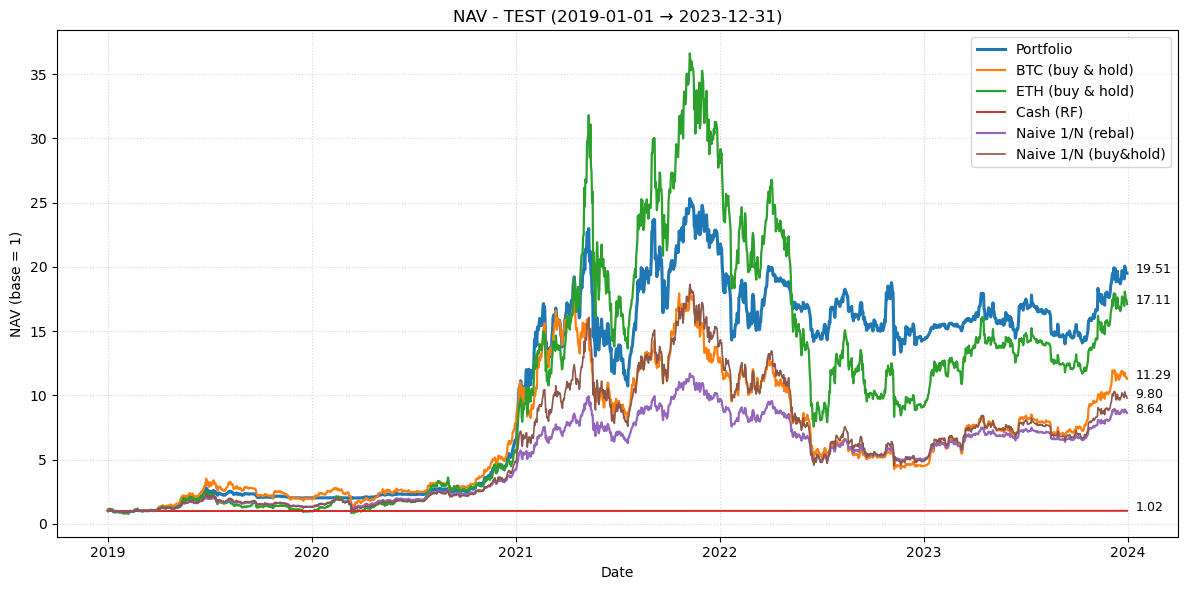

Saved NAV figure → QPM plots\NAV_-_TEST_2019-01-01_2023-12-31.png


In [11]:
# ===== STRICT TEST-WINDOW, RETURNS-ONLY =====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import datetime

# your test window
start_test = pd.Timestamp(datetime(2018, 12, 31)) + relativedelta(days=1)
end_test   = pd.Timestamp(2023, 12, 31)   # final_end_date

# === NAV plot (start here) ===

# 1) Build the daily index for the test window
idx = pd.date_range(start_test, end_test, freq="D")
n, m = len(df_total_port_r), len(idx)

# 2) Ensure chronological order (your 1970... ns index is increasing anyway)
df_total_port_r = df_total_port_r.sort_index()

# 3) Map returns to the test-window index
#    Strategy: align from the START (first return -> start_test).
#    If you prefer aligning from the END, change iloc[:m] to iloc[-m:].
if n >= m:
    # too many rows → trim to the first m and assign the test index
    df_total_port_r = df_total_port_r.iloc[:m].copy()
    df_total_port_r.index = idx
else:
    # too few rows → place them at the start of the window and pad the rest with 0 returns
    new = pd.DataFrame(index=idx, columns=["Port r"], dtype=float)
    new.iloc[:n, 0] = df_total_port_r["Port r"].values
    new = new.fillna(0.0)
    df_total_port_r = new

# 4) Helper: percent → decimal if needed
def to_decimal(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    return s/100.0 if s.abs().quantile(0.99) > 1.5 else s

# 5) Portfolio NAV (fill missing days already handled above)
port_nav = (1.0 + df_total_port_r["Port r"]).cumprod()

# 6) BTC / ETH buy & hold (use their own daily returns, forward-fill to idx)
btc_r = to_decimal(data["BTC%"]).loc[start_test:end_test].dropna()
eth_r = to_decimal(data["ETH%"]).loc[start_test:end_test].dropna()

btc_nav = pd.Series(1.0, index=idx, name="BTC (buy & hold)")
if not btc_r.empty:
    tmp = (1.0 + btc_r).cumprod()
    btc_nav.loc[tmp.index] = tmp
    btc_nav = btc_nav.ffill()

eth_nav = pd.Series(1.0, index=idx, name="ETH (buy & hold)")
if not eth_r.empty:
    tmp = (1.0 + eth_r).cumprod()
    eth_nav.loc[tmp.index] = tmp
    eth_nav = eth_nav.ffill()

# 7) Cash (risk-free) — constant daily rate unless you have a series
# 10-y treasury ~ 4% as of 10/3/2025
try:
    rf_annual = 1.04 ** (1/10) - 1
except Exception:
    rf_annual = 0.015
rf_day = pd.Series((1.0 + rf_annual)**(1/365.0) - 1.0, index=idx)
cash_nav = (1.0 + rf_day).cumprod()

# 7.5) Naive equal-weight (1/N) baselines
# Pick asset return columns (edit filter to your universe)
asset_cols_all = [c for c in data.columns if c.endswith('%')]

# If you want to use your selected/traded universe when available:
try:
    asset_pool = [c for c in optimal_assets_array if c in asset_cols_all]
    asset_cols = asset_pool if len(asset_pool) >= 2 else asset_cols_all
except NameError:
    asset_cols = asset_cols_all

# Drop assets with (near) zero variance across the window (e.g., stables)
# build a returns matrix aligned to the test window index
assets_r = pd.DataFrame(index=idx, columns=new_col, dtype=float)
for c in new_col:
    if c not in data.columns:
        print(f"[warn] {c} not found in data.columns; will be ignored.")
        continue
    s = to_decimal(data[c]).loc[start_test:end_test].dropna()
    assets_r.loc[s.index, c] = s.values

# daily rebalanced 1/N:
#   mean across *available* assets each day (skip NaNs), 0 if none available that day
ew_r_sel = assets_r.mean(axis=1, skipna=True).fillna(0.0)
ew_nav_sel = (1.0 + ew_r_sel).cumprod()
ew_nav_sel.name = "Naive 1/N (rebal, sel)"

# (optional) buy & hold 1/N on the same set (starts equal; weights drift)
bh_components_sel = (1.0 + assets_r.fillna(0.0)).cumprod()
bh_nav_sel = (bh_components_sel * (1.0 / len(new_col))).sum(axis=1)
bh_nav_sel.name = "Naive 1/N (buy&hold, sel)"

# 8) Assemble & plot
nav = pd.DataFrame({
    "Portfolio": port_nav,
    "BTC (buy & hold)": btc_nav,
    "ETH (buy & hold)": eth_nav,
    "Cash (RF)": cash_nav,
    "Naive 1/N (rebal)": ew_nav,
    "Naive 1/N (buy&hold)": bh_nav_1n
}, index=idx)

print("TEST WINDOW:", nav.index[0].date(), "→", nav.index[-1].date())

fig, ax = plt.subplots(figsize=(12, 6))
for name, lw in [
    ("Portfolio", 2.2),
    ("BTC (buy & hold)", 1.6),
    ("ETH (buy & hold)", 1.6),
    ("Cash (RF)", 1.4),
    ("Naive 1/N (rebal)", 1.6),
    ("Naive 1/N (buy&hold)", 1.2)
]:
    ax.plot(nav.index, nav[name], label=name, linewidth=lw)

ax.set_title(f"NAV - TEST ({idx[0].date()} → {idx[-1].date()})")
ax.set_xlabel("Date"); ax.set_ylabel("NAV (base = 1)")
ax.grid(True, linestyle=":", alpha=0.5); ax.legend(loc="best")

last = nav.index[-1]
for name in nav.columns:
    ax.annotate(f"{nav.loc[last, name]:.2f}",
                xy=(last, nav.loc[last, name]), xytext=(6, 0),
                textcoords="offset points", fontsize=9)
plt.tight_layout(); plt.show()
try:
    fname = _safe_name(ax.get_title(), fallback="nav_test")
    path  = _unique_path(outdir, fname, ext=".png")
except NameError:
    import re
    fname = re.sub(r"[^\w\- ]+", "", ax.get_title()).strip().replace(" ", "_") or "nav_test"
    path  = os.path.join(outdir, f"{fname}.png")

# save the figure
fig.savefig(path, dpi=300, bbox_inches="tight")
print(f"Saved NAV figure → {path}")

### Performance Report — From NAV (Daily → Annualized)

**Inputs**
- `nav`: DataFrame of strategy/benchmark NAV series (index = daily dates).
- `rf_day`: Series of daily risk-free rates aligned to `nav.index`.
- Optional benchmark for info ratio: `"BTC (buy & hold)"` column in `nav`.

**Helpers**
- `_years_between(ix)`: span in years from first to last date.
- `_max_drawdown(nav)`: max drawdown %, longest DD length (days), DD series.
- `_omega_ratio(r, thresh=0)`: Ω ratio on daily excess returns.
- `_var_cvar(r, q=0.05)`: daily VaR/CVaR at 95%.
- `_perf_from_nav(nav, rf_daily, periods_per_year=365, bench_r=None)`:
  - Compute daily returns `r` and excess `rx = r - rf`.
  - Metrics:
    - **CAGR**
    - **Ann. Vol**
    - **Sharpe (excess)** (annualized)
    - **Sortino** (annualized)
    - **Max Drawdown**, **Max DD Length (days)**
    - **Calmar**
    - **Omega (0%)**
    - **Hit Rate**
    - **VaR 95% (daily)**, **CVaR 95% (daily)**
    - **Skew**, **Kurtosis**
    - **Info Ratio vs Bench** (if `bench_r` provided)

**Per-Strategy Table**
- For each `nav` column:
  - Call `_perf_from_nav(...)` (use BTC buy-&-hold daily returns as `bench_r` if present).
- Assemble to `perf = DataFrame`, then pretty-format:
  - Percent columns shown as `%`.
  - Others to 2 decimals (or `-` if NaN).

**Calendar-Year Returns**
- `yr_nav = nav.resample("Y").last()` → `yr_rets = yr_nav.pct_change()`.
- Format as percent strings; index shown as years.

**Display / Export**
- Print or `display(perf_disp)` and `yr_disp`.
- (Optional) Save CSVs:
  - `perf_disp.to_csv("performance_summary.csv")`
  - `yr_disp.to_csv("calendar_year_returns.csv")`

**Notes**
- Handles empty/NaN NAVs safely; returns NaNs for metrics if insufficient data.
- Annualization assumes **365** trading days (crypto). Adjust `periods_per_year` if needed.
- `Info Ratio` computed on **daily** active returns vs selected benchmark.


In [13]:
# ===================== Fund-style performance report (updated) =====================
import numpy as np
import pandas as pd

# --- helpers ---
def _years_between(ix: pd.DatetimeIndex) -> float:
    ix = ix.sort_values()
    days = (ix[-1] - ix[0]).days
    return max(days, 1) / 365.25

def _max_drawdown(nav: pd.Series):
    nav = nav.dropna()
    if nav.empty:
        return np.nan, 0, pd.Series([], dtype=float, index=nav.index)
    roll_max = nav.cummax()
    dd = nav / roll_max - 1.0
    max_dd = dd.min()  # negative number
    in_dd = dd < 0
    grp = (in_dd != in_dd.shift()).cumsum()
    dd_durations = in_dd.groupby(grp).cumsum()
    max_len = int(dd_durations.max()) if not dd_durations.empty else 0
    return float(max_dd), max_len, dd

def _omega_ratio(r: pd.Series, thresh=0.0):
    r = pd.to_numeric(r, errors="coerce").dropna()
    if r.empty: return np.nan
    excess = r - thresh
    gains = excess[excess > 0].sum()
    losses = -excess[excess < 0].sum()
    return np.nan if losses == 0 else float(gains / losses)

def _var_cvar(r: pd.Series, q=0.05):
    r = pd.to_numeric(r, errors="coerce").dropna()
    if r.empty: return np.nan, np.nan
    qret = r.quantile(q)
    var = -qret
    cvar = -r[r <= qret].mean()
    return float(var), float(cvar)

def _perf_from_nav(nav: pd.Series, rf_daily: pd.Series, periods_per_year=365, bench_r: pd.Series=None):
    nav = pd.to_numeric(nav, errors="coerce").dropna()
    if nav.empty or nav.iloc[0] <= 0:
        return {k: np.nan for k in [
            "CAGR","Ann. Vol","Sharpe (excess)","Sortino","Max Drawdown",
            "Max DD Length (days)","Calmar","Omega (0%)","Hit Rate",
            "VaR 95% (daily)","CVaR 95% (daily)","Skew","Kurtosis","Info Ratio vs Bench"
        ]}

    # daily returns
    r = nav.pct_change().dropna()
    rf = rf_daily.reindex(r.index).fillna(0.0)
    rx = r - rf  # daily excess

    years = _years_between(nav.index)
    cagr = nav.iloc[-1] ** (1 / years) - 1.0

    # annualization
    mu_excess_daily = rx.mean()
    vol_daily = r.std(ddof=0)
    vol_excess_daily = rx.std(ddof=0)
    ann_vol = vol_daily * np.sqrt(periods_per_year)

    # Sharpe & Sortino (annualized)
    sharpe = (np.sqrt(periods_per_year) * mu_excess_daily / vol_excess_daily) if vol_excess_daily > 0 else np.nan
    downside = rx.mask(rx > 0, 0.0)  # keep negatives
    downside_std_daily = downside.std(ddof=0)
    sortino = (np.sqrt(periods_per_year) * mu_excess_daily / downside_std_daily) if downside_std_daily > 0 else np.nan

    max_dd, max_dd_len, dd_series = _max_drawdown(nav)
    calmar = (cagr / abs(max_dd)) if pd.notna(max_dd) and abs(max_dd) > 1e-12 else np.nan

    omega = _omega_ratio(rx)
    hit_rate = (r > 0).mean() if not r.empty else np.nan
    var95, cvar95 = _var_cvar(r, q=0.05)
    skew = r.skew()
    kurt = r.kurt()

    # Optional: information ratio vs benchmark (daily)
    info_ratio = np.nan
    if bench_r is not None:
        br = pd.to_numeric(bench_r, errors="coerce").reindex(r.index).dropna()
        rr = r.reindex(br.index).dropna()
        if not rr.empty:
            active = rr - br
            mu_a = active.mean()
            sig_a = active.std(ddof=0)
            info_ratio = (np.sqrt(periods_per_year) * mu_a / sig_a) if sig_a > 0 else np.nan

    return {
        "CAGR": cagr,
        "Ann. Vol": ann_vol,
        "Sharpe (excess)": sharpe,
        "Sortino": sortino,
        "Max Drawdown": max_dd,         # negative number
        "Max DD Length (days)": max_dd_len,
        "Calmar": calmar,
        "Omega (0%)": omega,
        "Hit Rate": hit_rate,
        "VaR 95% (daily)": var95,
        "CVaR 95% (daily)": cvar95,
        "Skew": skew,
        "Kurtosis": kurt,
        "Info Ratio vs Bench": info_ratio,
    }

# --- compute per-strategy metrics ---
# Optionally choose a benchmark return series for Info Ratio (e.g., BTC buy & hold)
bench_name = "BTC (buy & hold)"
bench_r_daily = nav[bench_name].pct_change().dropna() if bench_name in nav.columns else None

perf_rows = {}
for col in nav.columns:
    perf_rows[col] = _perf_from_nav(
        nav[col], rf_day, periods_per_year=365,
        bench_r=bench_r_daily if bench_r_daily is not None else None
    )

perf = pd.DataFrame(perf_rows).T

# pretty formatting
fmt_cols_pct = ["CAGR", "Ann. Vol", "Max Drawdown", "Hit Rate", "VaR 95% (daily)", "CVaR 95% (daily)"]
perf_disp = perf.copy()
for c in fmt_cols_pct:
    if c in perf_disp:
        perf_disp[c] = perf_disp[c].apply(lambda x: np.nan if pd.isna(x) else f"{x*100:,.2f}%")
for c in ["Sharpe (excess)", "Sortino", "Calmar", "Omega (0%)", "Skew", "Kurtosis", "Info Ratio vs Bench", "Max DD Length (days)"]:
    if c in perf_disp.columns:
        perf_disp[c] = perf_disp[c].apply(lambda x: "-" if pd.isna(x) else (f"{x:,.2f}" if c != "Max DD Length (days)" else f"{int(x):,}"))

print("\n=== Performance Summary (Daily → Annualized) ===")
try:
    display(perf_disp)  # Jupyter
except NameError:
    print(perf_disp)

# --- calendar-year returns table ---
yr_nav = nav.resample("Y").last()
yr_rets = yr_nav.pct_change().dropna()
yr_rets.index = yr_rets.index.year  # show as 2019, 2020, ...

yr_disp = (yr_rets * 100).round(2).astype(str) + "%"
print("\n=== Calendar-Year Returns ===")
try:
    display(yr_disp)
except NameError:
    print(yr_disp)
# Optional: save to CSV
# perf_disp.to_csv("performance_summary.csv", index=True)
# yr_disp.to_csv("calendar_year_returns.csv", index=True)



=== Performance Summary (Daily → Annualized) ===


,CAGR,Ann. Vol,Sharpe (excess),Sortino,Max Drawdown,Max DD Length (days),Calmar,Omega (0%),Hit Rate,VaR 95% (daily),CVaR 95% (daily),Skew,Kurtosis,Info Ratio vs Bench
Portfolio,81.23%,58.56%,1.29,2.17,-53.33%,783,1.52,1.25,51.67%,4.37%,7.07%,0.24,8.09,0.13
BTC (buy & hold),62.44%,66.45%,1.05,1.73,-76.72%,783,0.81,1.18,51.73%,5.09%,7.95%,-0.32,8.87,-
ETH (buy & hold),76.53%,85.65%,1.09,1.78,-79.33%,783,0.96,1.18,51.78%,6.57%,10.23%,-0.40,7.98,0.47
Cash (RF),0.39%,0.00%,-,-,0.00%,0,-,-,100.00%,-0.00%,-0.00%,0.00,0.00,-1.05
Naive 1/N (rebal),53.96%,48.54%,1.12,1.78,-59.47%,783,0.91,1.19,52.27%,3.81%,5.93%,-0.67,9.17,-0.59
Naive 1/N (buy&hold),57.90%,65.90%,1.01,1.61,-75.72%,783,0.76,1.17,52.38%,5.15%,8.21%,-0.57,6.59,-0.12



=== Calendar-Year Returns ===


C:\Users\Panuruj\AppData\Local\Temp\ipykernel_25820\1204940536.py:137: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yr_nav = nav.resample("Y").last()


,Portfolio,BTC (buy & hold),ETH (buy & hold),Cash (RF),Naive 1/N (rebal),Naive 1/N (buy&hold)
2020,216.15%,303.36%,471.75%,0.39%,215.86%,268.62%
2021,228.66%,59.6%,399.1%,0.39%,126.01%,187.27%
2022,-31.96%,-64.29%,-67.54%,0.39%,-47.41%,-64.94%
2023,36.3%,152.08%,87.96%,0.39%,72.5%,101.65%
